# 📦 PHẦN 1: TẢI VÀ XỬ LÝ DỮ LIỆU

---

**Mục tiêu:**
1. Tải dataset Multi30K (English → French)
2. Tokenization với SpaCy
3. Xây dựng Vocabulary với special tokens: `<unk>`, `<pad>`, `<sos>`, `<eos>`
4. Tạo DataLoader với sorting + padding (sẵn sàng cho LSTM)

---

## 1.1 Environment Setup and Dataset Preparation

Trong cell này, chúng tôi thực hiện **cài đặt môi trường làm việc và chuẩn bị dữ liệu** cho đồ án Neural Machine Translation (Anh → Pháp).

### Library Installation
- Sử dụng **Google Colab** làm môi trường thực thi.
- Cài đặt các thư viện cần thiết:
  - **PyTorch** và **TorchText** cho việc xây dựng và huấn luyện mô hình Seq2Seq.
  - **SpaCy** cho tokenization tiếng Anh và tiếng Pháp.
  - **NLTK** phục vụ cho bước đánh giá BLEU score.
- Phiên bản thư viện được cố định nhằm đảm bảo **tính ổn định và khả năng tái lập kết quả**.

### Environment Configuration
- Thiết lập **random seed** để đảm bảo tính reproducibility của quá trình huấn luyện.
- Tự động phát hiện và sử dụng **GPU (CUDA)** nếu khả dụng, giúp tăng tốc quá trình training.
- In ra thông tin phiên bản thư viện và thiết bị để xác nhận môi trường đã được cấu hình đúng.

### Dataset Preparation (Multi30K)
- Tải bộ dữ liệu **Multi30K (English–French)** trực tiếp từ nguồn chính thức.
- Dữ liệu được chia sẵn thành ba tập:
  - **Training**
  - **Validation**
  - **Test**
- Các file nén được giải nén và lưu trữ trong thư mục `data/` để thuận tiện cho các bước xử lý tiếp theo.

Bước chuẩn bị này đảm bảo rằng **môi trường thực thi và dữ liệu đầu vào đã sẵn sàng**, tạo nền tảng cho các bước **đọc dữ liệu, tokenization và xây dựng mô hình Seq2Seq** ở các phần tiếp theo.


In [ ]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & CẤU HÌNH
# ==============================================================================

# Khắc phục lỗi NumPy và cài đặt lại các thư viện chính
# Hạ cấp NumPy để giải quyết lỗi tương thích với Thinc/SpaCy
!pip install "numpy<2.0.0" -q

# Cài đặt thư viện (chạy trên Google Colab)
!pip install torch==2.2.2 torchtext==0.17.2 -q
!pip install spacy nltk -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download fr_core_news_sm -q

# Import thư viện
import torch
import torch.nn as nn
import torch.nn.functional as F  # Cần cho Attention
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import io
import os
import random

# =============================================================================
# SEED cho Reproducibility
# =============================================================================
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ Torch version: {torch.__version__}")
print(f"✅ Torchtext version: {torchtext.__version__}")
print(f"✅ Device: {device}")
print(f"✅ Seed: {SEED}")

# =============================================================================
# TẢI DATASET MULTI30K (EN-FR)
# =============================================================================
!mkdir -p data
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz -O data/train.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.fr.gz -O data/train.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz -O data/val.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.fr.gz -O data/val.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz -O data/test.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.fr.gz -O data/test.fr.gz

# Giải nén
!gunzip -kf data/*.gz
!ls -la data/

print("\n✅ Đã chuẩn bị xong dữ liệu và thư viện!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 110.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
torchvision 0.24.0+cu126 requires torch==2.9.0, but you have torch 2.2.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; pytho

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/NMT_EN_FR_Final1"
os.makedirs(BASE_DIR, exist_ok=True)

print("Saving to:", BASE_DIR)


Saving to: /content/drive/MyDrive/NMT_EN_FR_Final1


## 1.2 Data Loading and Inspection

Trong bước này, chúng tôi tiến hành **đọc và kiểm tra dữ liệu song ngữ Anh–Pháp** từ bộ dữ liệu Multi30K, bao gồm ba tập riêng biệt: **training, validation và test**.

### Data Loading
- Dữ liệu được đọc trực tiếp từ các file văn bản:
  - `train.en` / `train.fr`
  - `val.en` / `val.fr`
  - `test.en` / `test.fr`
- Mỗi dòng trong file tương ứng với **một câu**, và các cặp câu Anh–Pháp được **căn chỉnh 1–1**.
- Các dòng trống được loại bỏ nhằm đảm bảo dữ liệu sạch.

### Data Consistency Check
- Thực hiện kiểm tra số lượng câu giữa hai ngôn ngữ bằng cách so sánh độ dài danh sách câu.
- Điều này đảm bảo **không xảy ra lệch cặp câu**, một yêu cầu quan trọng trong bài toán dịch máy.

### Dataset Statistics and Examples
- Sau khi đọc dữ liệu, hệ thống in ra:
  - Số lượng cặp câu trong từng tập (train/validation/test)
- Hiển thị một số **ví dụ cặp câu đầu tiên** từ tập train nhằm:
  - Xác nhận dữ liệu được đọc đúng
  - Kiểm tra nhanh chất lượng và định dạng dữ liệu

Bước kiểm tra này giúp đảm bảo dữ liệu đầu vào **đúng, đầy đủ và nhất quán** trước khi chuyển sang các bước xử lý tiếp theo như **tokenization và xây dựng vocabulary**.


In [ ]:
# ==============================================================================
# CELL 1.2: ĐỌC VÀ KIỂM TRA DỮ LIỆU
# ==============================================================================

def read_data(en_file, fr_file):
    """
    Đọc dữ liệu song ngữ từ file.

    Returns:
        en_sentences: List câu tiếng Anh
        fr_sentences: List câu tiếng Pháp (căn chỉnh 1-1)
    """
    with open(en_file, 'r', encoding='utf-8') as f:
        en_sentences = [line.strip() for line in f.readlines() if line.strip()]
    with open(fr_file, 'r', encoding='utf-8') as f:
        fr_sentences = [line.strip() for line in f.readlines() if line.strip()]

    # Đảm bảo số câu khớp nhau
    assert len(en_sentences) == len(fr_sentences), "Số câu EN và FR không khớp!"
    return en_sentences, fr_sentences

# Đọc dữ liệu train, val, test từ folder 'data/'
train_en, train_fr = read_data('data/train.en', 'data/train.fr')
val_en, val_fr = read_data('data/val.en', 'data/val.fr')
test_en, test_fr = read_data('data/test.en', 'data/test.fr')

print("=" * 50)
print("📊 THỐNG KÊ DỮ LIỆU MULTI30K")
print("=" * 50)
print(f"   Train:      {len(train_en):,} cặp câu")
print(f"   Validation: {len(val_en):,} cặp câu")
print(f"   Test:       {len(test_en):,} cặp câu")
print("=" * 50)

# Hiển thị ví dụ
print("\n📝 VÍ DỤ 5 CẶP CÂU ĐẦU TIÊN:")
for i in range(5):
    print(f"\nExample {i+1}:")
    print(f"   EN: {train_en[i]}")
    print(f"   FR: {train_fr[i]}")

📊 THỐNG KÊ DỮ LIỆU MULTI30K
   Train:      29,000 cặp câu
   Validation: 1,014 cặp câu
   Test:       1,000 cặp câu

📝 VÍ DỤ 5 CẶP CÂU ĐẦU TIÊN:

Example 1:
   EN: Two young, White males are outside near many bushes.
   FR: Deux jeunes hommes blancs sont dehors près de buissons.

Example 2:
   EN: Several men in hard hats are operating a giant pulley system.
   FR: Plusieurs hommes en casque font fonctionner un système de poulies géant.

Example 3:
   EN: A little girl climbing into a wooden playhouse.
   FR: Une petite fille grimpe dans une maisonnette en bois.

Example 4:
   EN: A man in a blue shirt is standing on a ladder cleaning a window.
   FR: Un homme dans une chemise bleue se tient sur une échelle pour nettoyer une fenêtre.

Example 5:
   EN: Two men are at the stove preparing food.
   FR: Deux hommes aux fourneaux préparent à manger.


## 1.3 Tokenization & Vocabulary Construction

Trong bước này, chúng tôi thực hiện **tokenization** và **xây dựng vocabulary** cho hai ngôn ngữ nguồn (English) và đích (French), đây là bước quan trọng nhằm chuyển dữ liệu văn bản thô thành dạng số để mô hình có thể xử lý.

### Tokenization
- Sử dụng **SpaCy tokenizer** cho cả tiếng Anh (`en_core_web_sm`) và tiếng Pháp (`fr_core_news_sm`).
- SpaCy được lựa chọn vì khả năng xử lý từ vựng và dấu câu ổn định, phù hợp cho bài toán dịch máy.
- Việc tách tokenizer thành hàm riêng giúp dễ kiểm soát lỗi và tái sử dụng trong các bước sau.

### Vocabulary Construction
- Vocabulary được xây dựng **chỉ từ tập train**, đảm bảo không rò rỉ thông tin từ validation/test.
- Áp dụng các ràng buộc:
  - `min_freq = 2`: loại bỏ các từ xuất hiện quá ít nhằm giảm nhiễu.
  - `max_tokens = 10,000`: giới hạn kích thước vocabulary để kiểm soát độ phức tạp của mô hình.
- Các **special tokens** được thêm thủ công:
  - `<unk>`: từ ngoài vocabulary (OOV)
  - `<pad>`: padding cho các chuỗi có độ dài khác nhau
  - `<sos>`: ký hiệu bắt đầu câu
  - `<eos>`: ký hiệu kết thúc câu
- Chỉ số mặc định (`default_index`) được gán cho `<unk>` để đảm bảo các từ chưa từng xuất hiện trong training được xử lý an toàn.

### Kiểm tra và xác nhận
- Sau khi xây dựng vocabulary, hệ thống in ra:
  - Kích thước vocabulary của mỗi ngôn ngữ
  - Thứ tự index của các special tokens
- Thực hiện kiểm tra OOV bằng cách truy vấn một từ không tồn tại để xác nhận rằng từ này được ánh xạ đúng về `<unk>`.

Bước này đảm bảo dữ liệu đầu vào được chuẩn hóa đầy đủ, tạo tiền đề cho các bước **numericalization, padding và huấn luyện mô hình Seq2Seq** ở các phần tiếp theo.


In [ ]:
# ==============================================================================
# CELL 1.3: TOKENIZATION & VOCABULARY
# ==============================================================================

# --- CẤU HÌNH TOKEN ĐẶC BIỆT ---
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
SPECIAL_SYMBOLS = ['<unk>', '<pad>', '<sos>', '<eos>']

# =============================================================================
# HÀM: get_tokenizers()
# Nhiệm vụ: Tải tokenizer của SpaCy cho tiếng Anh và Pháp
# =============================================================================
def get_tokenizers():
    try:
        en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
        fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
        print("✅ Đã tải thành công Tokenizer (SpaCy)")
        return en_tokenizer, fr_tokenizer
    except OSError:
        print("❌ Lỗi: Chưa tìm thấy model SpaCy. Hãy chạy lại Cell 1.1")
        return None, None

# =============================================================================
# HÀM: build_vocab()
# Nhiệm vụ: Xây dựng vocabulary từ file dữ liệu
# =============================================================================
def build_vocab(filepath, tokenizer):
    """
    Xây dựng vocabulary từ file text.

    Args:
        filepath: Đường dẫn file text
        tokenizer: Tokenizer function

    Returns:
        vocab: Vocabulary object với special tokens
    """
    def yield_tokens(path):
        with io.open(path, encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    yield tokenizer(line.strip())

    print(f"   Đang xây dựng vocab từ {filepath}...")

    vocab = build_vocab_from_iterator(
        yield_tokens(filepath),
        min_freq=2,           # Bỏ qua từ xuất hiện < 2 lần
        max_tokens=10000,     # Giới hạn vocabulary size
        specials=SPECIAL_SYMBOLS
    )

    # Set default index cho từ không có trong vocab (OOV)
    vocab.set_default_index(UNK_IDX)
    return vocab

# =============================================================================
# THỰC THI
# =============================================================================
tokenizer_en, tokenizer_fr = get_tokenizers()

if tokenizer_en and tokenizer_fr:
    print("\n Xây dựng Vocabulary:")
    vocab_en = build_vocab('data/train.en', tokenizer_en)
    vocab_fr = build_vocab('data/train.fr', tokenizer_fr)

    print("\n" + "=" * 50)
    print("BÁO CÁO VOCABULARY")
    print("=" * 50)
    print(f"   Vocab EN: {len(vocab_en):,} tokens (max: 10,004)")
    print(f"   Vocab FR: {len(vocab_fr):,} tokens (max: 10,004)")
    print(f"   Special tokens: <unk>={UNK_IDX}, <pad>={PAD_IDX}, <sos>={SOS_IDX}, <eos>={EOS_IDX}")

    # Kiểm tra xử lý từ lạ (OOV)
    test_oov = vocab_en['từ_không_tồn_tại_xyz']
    if test_oov == UNK_IDX:
        print("   OOV handling: ✅ Thành công (trả về index 0)")
    else:
        print(f"   OOV handling: ❌ Thất bại (trả về {test_oov})")
    print("=" * 50)

✅ Đã tải thành công Tokenizer (SpaCy)

 Xây dựng Vocabulary:
   Đang xây dựng vocab từ data/train.en...
   Đang xây dựng vocab từ data/train.fr...

BÁO CÁO VOCABULARY
   Vocab EN: 6,191 tokens (max: 10,004)
   Vocab FR: 6,555 tokens (max: 10,004)
   Special tokens: <unk>=0, <pad>=1, <sos>=2, <eos>=3
   OOV handling: ✅ Thành công (trả về index 0)


## 1.4 Text Transformation (Numericalization)

Trong bước này, chúng tôi thực hiện **chuyển đổi văn bản sang dạng số (numericalization)**, một bước trung gian quan trọng giúp mô hình Seq2Seq có thể xử lý dữ liệu ngôn ngữ tự nhiên.

### Text Transformation Pipeline
Quy trình chuyển đổi được thực hiện theo các bước sau:

1. **Tokenization**:  
   Câu đầu vào được tách thành các token bằng tokenizer đã xây dựng ở bước trước.
2. **Vocabulary Mapping**:  
   Mỗi token được ánh xạ sang chỉ số tương ứng trong vocabulary.  
   Các token không tồn tại trong vocabulary sẽ được ánh xạ về `<unk>`.
3. **Special Tokens Insertion**:  
   - `<sos>` (start-of-sentence) được thêm vào đầu câu.
   - `<eos>` (end-of-sentence) được thêm vào cuối câu.  

Kết quả cuối cùng là một **tensor số nguyên 1 chiều**, đại diện cho một câu hoàn chỉnh sẵn sàng đưa vào mô hình.

### Validation of the Transformation
Để đảm bảo pipeline hoạt động chính xác, chúng tôi:
- Kiểm tra trực tiếp từng bước: câu gốc → tokens → tensor.
- Xác nhận:
  - Kiểu dữ liệu của tensor (`torch.long`)
  - Thứ tự và vị trí của `<sos>` và `<eos>`

Việc kiểm tra này giúp đảm bảo rằng dữ liệu đầu vào được chuẩn hóa đúng định dạng, tạo tiền đề cho các bước **padding, batching và huấn luyện mô hình** trong các phần tiếp theo.


In [ ]:
# ==============================================================================
# CELL 1.4: TEXT TRANSFORM (Numericalization)
# ==============================================================================

def text_transform(text, tokenizer, vocab):
    """
    Chuyển đổi câu text thành tensor số.

    Pipeline: text → tokens → token_ids → tensor với <sos> và <eos>

    Args:
        text: Câu input (string)
        tokenizer: Tokenizer function
        vocab: Vocabulary object

    Returns:
        tensor: [SOS, token_ids..., EOS]
    """
    tokens = tokenizer(text)
    token_ids = [vocab[token] for token in tokens]
    return torch.tensor([SOS_IDX] + token_ids + [EOS_IDX], dtype=torch.long)

# =============================================================================
# KIỂM TRA TEXT PIPELINE
# =============================================================================
print("=" * 50)
print("🔍 KIỂM TRA TEXT PIPELINE")
print("=" * 50)

sample_sentence = "Two young, White males are outside."
print(f"1. Câu gốc:     '{sample_sentence}'")

# Tokenize
sample_tokens = tokenizer_en(sample_sentence)
print(f"2. Tokens:      {sample_tokens}")

# Transform
sample_tensor = text_transform(sample_sentence, tokenizer_en, vocab_en)
print(f"3. Tensor:      {sample_tensor}")
print(f"4. Shape:       {sample_tensor.shape}")
print(f"5. Dtype:       {sample_tensor.dtype}")

# Kiểm tra logic <sos> và <eos>
if sample_tensor[0] == SOS_IDX and sample_tensor[-1] == EOS_IDX:
    print("\n✅ Logic <sos>/<eos>: ĐÚNG (đầu=2, cuối=3)")
else:
    print(f"\n❌ Logic <sos>/<eos>: SAI (đầu={sample_tensor[0]}, cuối={sample_tensor[-1]})")
print("=" * 50)

🔍 KIỂM TRA TEXT PIPELINE
1. Câu gốc:     'Two young, White males are outside.'
2. Tokens:      ['Two', 'young', ',', 'White', 'males', 'are', 'outside', '.']
3. Tensor:      tensor([   2,   19,   25,   15, 1169,  808,   17,   57,    5,    3])
4. Shape:       torch.Size([10])
5. Dtype:       torch.int64

✅ Logic <sos>/<eos>: ĐÚNG (đầu=2, cuối=3)


## 1.5 Dataset, Collate Function and DataLoader

Trong bước này, chúng tôi xây dựng **pipeline batching hoàn chỉnh** cho bài toán dịch máy, bao gồm **Dataset**, **collate function** và **DataLoader**. Mục tiêu là đảm bảo dữ liệu đầu vào được chuẩn hóa đúng định dạng và tương thích với mô hình **Seq2Seq sử dụng LSTM**.

### Custom Dataset
- Định nghĩa lớp `TranslationDataset` để lưu trữ các cặp câu song ngữ *(source, target)* dưới dạng văn bản.
- Dataset chỉ chịu trách nhiệm quản lý dữ liệu, trong khi các bước chuyển đổi sang tensor được xử lý ở `collate_fn`.
- Kiểm tra độ dài hai danh sách câu nhằm đảm bảo **căn chỉnh 1–1 giữa source và target**.

### Collate Function
Hàm `collate_fn` được sử dụng để xử lý từng batch dữ liệu với các bước sau:

1. **Text Transformation**  
   Chuyển câu nguồn và câu đích từ dạng text sang tensor số bằng pipeline đã xây dựng ở bước 1.4.

2. **Padding**  
   Các chuỗi trong batch được padding về cùng độ dài bằng token `<pad>`, giúp tạo tensor có kích thước đồng nhất.

3. **Length Computation and Sorting**  
   - Tính độ dài thực tế của từng câu nguồn.
   - Sắp xếp các câu theo độ dài giảm dần, đây là yêu cầu bắt buộc để sử dụng `pack_padded_sequence` trong LSTM.

Hàm `collate_fn` trả về:
- Tensor câu nguồn đã padding
- Tensor câu đích đã padding
- Vector độ dài thực tế của câu nguồn

### DataLoader
- Tạo các `DataLoader` riêng cho **training**, **validation** và **test**.
- Dữ liệu training được shuffle để tăng tính ngẫu nhiên trong huấn luyện.
- Validation và test giữ nguyên thứ tự để đảm bảo đánh giá nhất quán.
- Tất cả các DataLoader đều sử dụng chung `collate_fn` nhằm đảm bảo xử lý dữ liệu thống nhất.

### Validation of Data Pipeline
- Thực hiện kiểm tra một batch dữ liệu từ `train_loader` để xác nhận:
  - Kích thước tensor đúng định dạng `(sequence_length, batch_size)`
  - Batch đã được sort theo độ dài giảm dần
- Việc kiểm tra này xác nhận rằng pipeline dữ liệu đã **sẵn sàng cho việc huấn luyện mô hình Seq2Seq với LSTM và Attention** ở các phần tiếp theo.

Sau bước này, toàn bộ **pipeline xử lý dữ liệu** đã hoàn thiện, cho phép chuyển sang **PHẦN 2: Xây dựng mô hình**.


In [ ]:
# ==============================================================================
# CELL 1.5: DATASET, COLLATE_FN & DATALOADER
# ==============================================================================

# =============================================================================
# CLASS: TranslationDataset
# =============================================================================
class TranslationDataset(Dataset):
    """
    Dataset cho dữ liệu song ngữ.
    Lưu trữ cặp câu (source, target) dạng text.
    """
    def __init__(self, src_list, trg_list):
        self.src_list = src_list
        self.trg_list = trg_list
        assert len(src_list) == len(trg_list), "Số câu source và target không khớp!"

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, idx):
        return self.src_list[idx], self.trg_list[idx]

# =============================================================================
# HÀM: collate_fn
# Xử lý batch: padding + sorting theo độ dài (cho pack_padded_sequence)
# =============================================================================
def collate_fn(batch):
    """
    Xử lý batch dữ liệu:
    1. Chuyển text → tensor
    2. Padding để đồng bộ độ dài
    3. Sort theo độ dài giảm dần (yêu cầu cho pack_padded_sequence)

    Returns:
        src_padded: [src_len, batch_size]
        trg_padded: [trg_len, batch_size]
        sorted_lens: [batch_size] - độ dài thực của từng câu source
    """
    src_batch, trg_batch = [], []

    # Chuyển đổi Text → Tensor
    for src_sample, trg_sample in batch:
        src_batch.append(text_transform(src_sample, tokenizer_en, vocab_en))
        trg_batch.append(text_transform(trg_sample, tokenizer_fr, vocab_fr))

    # Padding (đồng bộ độ dài trong batch)
    src_padded = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_padded = pad_sequence(trg_batch, padding_value=PAD_IDX)

    # Tính độ dài thực tế của từng câu nguồn (dtype=long cho pack_padded_sequence)
    src_lens = torch.tensor([len(x) for x in src_batch], dtype=torch.long)

    # Sort giảm dần theo độ dài (yêu cầu của pack_padded_sequence với enforce_sorted=True)
    sorted_lens, sorted_indices = torch.sort(src_lens, descending=True)

    # Sắp xếp lại tensors theo thứ tự đã sort
    src_padded = src_padded[:, sorted_indices]
    trg_padded = trg_padded[:, sorted_indices]

    return src_padded, trg_padded, sorted_lens

# =============================================================================
# TẠO DATALOADER
# =============================================================================
BATCH_SIZE = 64

# Tạo Dataset
train_dataset = TranslationDataset(train_en, train_fr)
valid_dataset = TranslationDataset(val_en, val_fr)
test_dataset = TranslationDataset(test_en, test_fr)

# Tạo DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle cho training
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

# =============================================================================
# KIỂM TRA DATALOADER
# =============================================================================
print("=" * 50)
print("🔍 KIỂM TRA DATALOADER")
print("=" * 50)

try:
    src, trg, src_len = next(iter(train_loader))

    print(f"1. Source shape:   {src.shape} (seq_len, batch_size)")
    print(f"2. Target shape:   {trg.shape} (seq_len, batch_size)")
    print(f"3. Lengths shape:  {src_len.shape}")
    print(f"   - Câu dài nhất:  {src_len[0]} tokens")
    print(f"   - Câu ngắn nhất: {src_len[-1]} tokens")

    # Kiểm tra sorting
    if src_len[0] >= src_len[-1]:
        print("\n✅ Batch đã SORT theo độ dài (giảm dần)")
        print("   → Sẵn sàng cho pack_padded_sequence!")
    else:
        print("\n❌ Lỗi: Batch chưa được sort đúng!")

    print("\n" + "-" * 50)
    print(f"📊 SỐ BATCH:")
    print(f"   Train:      {len(train_loader)} batches")
    print(f"   Validation: {len(valid_loader)} batches")
    print(f"   Test:       {len(test_loader)} batches")
    print("=" * 50)
    print("\n✅ PHẦN 1 HOÀN TẤT - Sẵn sàng cho PHẦN 2 (Model)!")

except Exception as e:
    print(f"\n❌ LỖI: {e}")
    print("Gợi ý: Kiểm tra lại collate_fn có trả về đúng 3 giá trị không?")

🔍 KIỂM TRA DATALOADER
1. Source shape:   torch.Size([28, 64]) (seq_len, batch_size)
2. Target shape:   torch.Size([30, 64]) (seq_len, batch_size)
3. Lengths shape:  torch.Size([64])
   - Câu dài nhất:  28 tokens
   - Câu ngắn nhất: 8 tokens

✅ Batch đã SORT theo độ dài (giảm dần)
   → Sẵn sàng cho pack_padded_sequence!

--------------------------------------------------
📊 SỐ BATCH:
   Train:      454 batches
   Validation: 16 batches
   Test:       16 batches

✅ PHẦN 1 HOÀN TẤT - Sẵn sàng cho PHẦN 2 (Model)!


# 🏗️ PHẦN 2: XÂY DỰNG MÔ HÌNH BASELINE SEQ2SEQ

---

## Kiến trúc Encoder-Decoder LSTM (Không Attention)

```
┌────────────────────────────────────────────────────────────────┐
│                     BASELINE SEQ2SEQ ARCHITECTURE              │
├────────────────────────────────────────────────────────────────┤
│                                                                │
│  INPUT (EN)       ENCODER           DECODER        OUTPUT (FR) │
│  ─────────→      ────────→         ────────→      ──────────→  │
│                                                                │
│  "A man walks" → [LSTM x2] → (h,c) → [LSTM x2] → "Un homme..." │
│                              ↑                                 │
│                       Context Vector                           │
│                  (Fixed representation)                        │
│                                                                │
└────────────────────────────────────────────────────────────────┘
```

**Công thức:**
- Encoder: `(h_t, c_t) = LSTM(embed(x_t), (h_{t-1}, c_{t-1}))`
- Decoder: `(h_t, c_t) = LSTM(embed(y_{t-1}), (h'_{t-1}, c'_{t-1}))`
- Output:  `p(y_t) = softmax(Linear(h_t))`

**Hyperparameters:**

| Parameter | Value | Mô tả |
|-----------|-------|-------|
| `EMB_DIM` | 256 | Embedding dimension |
| `HID_DIM` | 512 | Hidden state dimension |
| `N_LAYERS` | 2 | Số lớp LSTM |
| `DROPOUT` | 0.5 | Dropout rate |

---

## 2.1 Baseline Seq2Seq Model Definition (Fixed Context Vector)

Trong phần này, chúng tôi xây dựng **mô hình Seq2Seq cơ bản (Baseline)** dựa trên kiến trúc **Encoder–Decoder sử dụng LSTM**, **không có Attention**.  
Mục tiêu của mô hình này là **thực hiện dịch máy với context vector cố định**, đúng theo yêu cầu cơ bản của đồ án.

### Encoder
- Encoder được cài đặt bằng **LSTM nhiều lớp**, có nhiệm vụ đọc toàn bộ câu nguồn.
- Để xử lý các chuỗi có độ dài khác nhau, chúng tôi sử dụng:
  - `pack_padded_sequence` kết hợp với batch đã được **sort theo độ dài giảm dần**.
- Sau khi đọc xong câu nguồn, Encoder **tóm tắt toàn bộ thông tin của câu** vào:
  - **Hidden states**
  - **Cell states**
- Trong mô hình baseline này, **hidden và cell states cuối cùng của Encoder đóng vai trò là context vector cố định**, được truyền trực tiếp sang Decoder.

> Lưu ý: Encoder **không trả về toàn bộ encoder outputs**, vì baseline Seq2Seq **không sử dụng cơ chế Attention**.

### Decoder
- Decoder cũng được cài đặt bằng **LSTM nhiều lớp**.
- Tại mỗi timestep, Decoder:
  - Nhận token đầu vào hiện tại
  - Sử dụng **context vector cố định (hidden & cell từ Encoder)** để sinh ra token tiếp theo của câu đích.
- Mỗi output của Decoder được ánh xạ qua một lớp `Linear` để dự đoán phân phối xác suất trên vocabulary đích.

### Seq2Seq Model
- Lớp `Seq2Seq` chịu trách nhiệm điều phối quá trình:
  - Encode câu nguồn
  - Decode câu đích theo từng timestep
- Mô hình hỗ trợ **teacher forcing**, cho phép sử dụng token ground truth với một tỷ lệ xác định trong quá trình huấn luyện.
- Output của mô hình là một tensor chứa logits cho toàn bộ câu đích.

### Weight Initialization
- Các tham số của mô hình được khởi tạo bằng **uniform distribution** trong khoảng `[-0.08, 0.08]`.
- Việc khởi tạo này giúp mô hình:
  - Hội tụ ổn định hơn trong giai đoạn đầu huấn luyện
  - Tránh hiện tượng gradient quá lớn

Mô hình Baseline Seq2Seq này đóng vai trò **mô hình cơ sở (baseline)** để:
- Chứng minh cơ chế **context vector cố định**
- Làm đối chứng cho mô hình **Seq2Seq có Attention** được trình bày ở các phần tiếp theo.


In [ ]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA CÁC CLASS MODEL
# ==============================================================================

# =============================================================================
# CLASS: Encoder
# =============================================================================
class Encoder(nn.Module):
    """
    Encoder LSTM cho Seq2Seq.

    Nhiệm vụ: Đọc câu nguồn và tạo context vector (hidden, cell states).
    Sử dụng pack_padded_sequence để xử lý padding hiệu quả.

    Args:
        input_dim: Kích thước vocabulary nguồn
        emb_dim: Embedding dimension
        hid_dim: Hidden state dimension
        n_layers: Số lớp LSTM
        dropout: Dropout rate
    """
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        """
        Forward pass của Encoder.

        Args:
            src: [src_len, batch_size] - Tensor câu nguồn
            src_len: [batch_size] - Độ dài thực của mỗi câu

        Returns:
            hidden: [n_layers, batch_size, hid_dim] - Hidden states
            cell: [n_layers, batch_size, hid_dim] - Cell states

        Note: Baseline KHÔNG trả về encoder_outputs (sẽ thêm khi có Attention)
        """
        # src: [src_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded: [src_len, batch_size, emb_dim]

        # Pack để LSTM không xử lý padding tokens
        packed_embedded = pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=True)

        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        # hidden: [n_layers, batch_size, hid_dim]
        # cell: [n_layers, batch_size, hid_dim]

        return hidden, cell


# =============================================================================
# CLASS: Decoder
# =============================================================================
class Decoder(nn.Module):
    """
    Decoder LSTM cho Seq2Seq (Baseline - không Attention).

    Nhiệm vụ: Sinh câu đích từng token một, dựa trên context từ Encoder.

    Args:
        output_dim: Kích thước vocabulary đích
        emb_dim: Embedding dimension
        hid_dim: Hidden state dimension
        n_layers: Số lớp LSTM
        dropout: Dropout rate
    """
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        """
        Forward pass của Decoder (1 timestep).

        Args:
            input: [batch_size] - Token hiện tại
            hidden: [n_layers, batch_size, hid_dim] - Hidden states
            cell: [n_layers, batch_size, hid_dim] - Cell states

        Returns:
            prediction: [batch_size, output_dim] - Logits cho vocabulary
            hidden: [n_layers, batch_size, hid_dim] - Updated hidden
            cell: [n_layers, batch_size, hid_dim] - Updated cell
        """
        # input: [batch_size] → [1, batch_size]
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))
        # embedded: [1, batch_size, emb_dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: [1, batch_size, hid_dim]

        prediction = self.fc_out(output.squeeze(0))
        # prediction: [batch_size, output_dim]

        return prediction, hidden, cell


# =============================================================================
# CLASS: Seq2Seq
# =============================================================================
class Seq2Seq(nn.Module):
    """
    Mô hình Seq2Seq Baseline (Encoder-Decoder không Attention).

    Điều phối Encoder và Decoder, xử lý teacher forcing.

    Args:
        encoder: Encoder instance
        decoder: Decoder instance
        device: 'cuda' hoặc 'cpu'
    """
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Đảm bảo encoder và decoder tương thích
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must match!"
        assert encoder.n_layers == decoder.n_layers, \
            "Number of layers of encoder and decoder must match!"

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        """
        Forward pass của Seq2Seq.

        Args:
            src: [src_len, batch_size] - Câu nguồn
            src_len: [batch_size] - Độ dài câu nguồn
            trg: [trg_len, batch_size] - Câu đích
            teacher_forcing_ratio: Tỷ lệ sử dụng ground truth (0.0 - 1.0)

        Returns:
            outputs: [trg_len, batch_size, output_dim] - Logits cho mỗi timestep
        """
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor lưu output của decoder tại mỗi timestep
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Encode câu nguồn
        hidden, cell = self.encoder(src, src_len)

        # Token đầu tiên là <sos>
        input = trg[0, :]

        # Decode từng timestep
        for t in range(1, trg_len):
            # Forward decoder
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Lưu output
            outputs[t] = output

            # Teacher Forcing: dùng ground truth hoặc prediction
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs


# =============================================================================
# HÀM: init_weights
# =============================================================================
def init_weights(m):
    """
    Khởi tạo weights cho model.
    - Weights: Uniform distribution [-0.08, 0.08]
    - Biases: 0
    """
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.uniform_(param.data, -0.08, 0.08)
        else:
            nn.init.constant_(param.data, 0)


print("✅ Đã định nghĩa: Encoder, Decoder, Seq2Seq, init_weights")

✅ Đã định nghĩa: Encoder, Decoder, Seq2Seq, init_weights


## 2.2 Baseline Model Initialization

Trong cell này, chúng tôi tiến hành **khởi tạo và kiểm tra mô hình Seq2Seq Baseline**, sử dụng **context vector cố định** theo đúng yêu cầu cơ bản của đồ án.

### Model Configuration
- Mô hình bao gồm:
  - **Encoder LSTM**
  - **Decoder LSTM**
- Không sử dụng **Attention mechanism**.
- Context vector được xác định bởi:
  - **Hidden state cuối cùng**
  - **Cell state cuối cùng**
  của Encoder, và được truyền trực tiếp sang Decoder.

Các hyperparameters chính:
- Embedding dimension cho Encoder và Decoder
- Hidden state dimension
- Số lớp LSTM
- Dropout rate  
Những tham số này được lựa chọn nhằm cân bằng giữa:
- Khả năng biểu diễn của mô hình
- Chi phí tính toán trong quá trình huấn luyện

### Baseline Model Initialization
- Encoder và Decoder được kết hợp thành mô hình `Seq2Seq`.
- Mô hình được đặt tên rõ ràng là **`baseline_model`** để phân biệt với mô hình có Attention ở các phần sau.
- Áp dụng **weight initialization** thống nhất để:
  - Giúp quá trình huấn luyện ổn định
  - Giảm ảnh hưởng của khởi tạo ngẫu nhiên

### Model Inspection
- Thực hiện thống kê:
  - Kích thước vocabulary đầu vào và đầu ra
  - Số lượng tham số huấn luyện
- Các thông tin này giúp đánh giá sơ bộ độ phức tạp của mô hình baseline.

### Forward Pass Validation
- Thực hiện một **forward pass kiểm tra** với một batch dữ liệu từ tập huấn luyện.
- Kiểm tra:
  - Tính tương thích giữa dữ liệu và mô hình
  - Kích thước tensor đầu ra của mô hình
- Việc kiểm tra này nhằm đảm bảo rằng **Baseline Seq2Seq model hoạt động đúng về mặt hình dạng dữ liệu**, sẵn sàng cho bước huấn luyện ở phần tiếp theo.

Mô hình Baseline này đóng vai trò **mô hình cơ sở (baseline)**, sử dụng **context vector cố định**, và được dùng làm **đối chứng** khi so sánh với mô hình Seq2Seq có Attention ở các phần sau của đồ án.


In [ ]:
# ==============================================================================
# CELL 2.2: KHỞI TẠO BASELINE MODEL (FIXED CONTEXT VECTOR)
# ==============================================================================
# ⚠️ ĐÂY LÀ MÔ HÌNH BASELINE - SỬ DỤNG CONTEXT VECTOR CỐ ĐỊNH
# (hidden state cuối cùng của Encoder, KHÔNG có Attention)

# =============================================================================
# HYPERPARAMETERS
# =============================================================================
INPUT_DIM = len(vocab_en)    # Vocab size tiếng Anh
OUTPUT_DIM = len(vocab_fr)   # Vocab size tiếng Pháp
ENC_EMB_DIM = 256            # Encoder embedding dim
DEC_EMB_DIM = 256            # Decoder embedding dim
HID_DIM = 512                # Hidden state dim
N_LAYERS = 2                 # Số lớp LSTM
ENC_DROPOUT = 0.5            # Encoder dropout
DEC_DROPOUT = 0.5            # Decoder dropout

# =============================================================================
# KHỞI TẠO BASELINE MODEL
# =============================================================================
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# ⚠️ QUAN TRỌNG: Đặt tên biến là baseline_model để phân biệt với attention_model
baseline_model = Seq2Seq(enc, dec, device).to(device)

# Áp dụng weight initialization
baseline_model.apply(init_weights)

# Đếm parameters
baseline_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)

print("=" * 60)
print("🏗️ MÔ HÌNH BASELINE SEQ2SEQ (FIXED CONTEXT VECTOR)")
print("=" * 60)
print("📌 Đặc điểm: Sử dụng CONTEXT VECTOR CỐ ĐỊNH")
print("   (Chỉ dùng hidden state cuối cùng của Encoder)")
print("-" * 60)
print(f"Device:           {device}")
print(f"Input dim (EN):   {INPUT_DIM:,}")
print(f"Output dim (FR):  {OUTPUT_DIM:,}")
print(f"Embedding dim:    {ENC_EMB_DIM}")
print(f"Hidden dim:       {HID_DIM}")
print(f"Num layers:       {N_LAYERS}")
print(f"Dropout:          {ENC_DROPOUT}")
print("-" * 60)
print(f"Total parameters: {baseline_params:,}")
print("=" * 60)

# =============================================================================
# KIỂM TRA KẾT NỐI DATA → MODEL
# =============================================================================
print("\n" + "=" * 60)
print("🔍 KIỂM TRA FORWARD PASS (BASELINE)")
print("=" * 60)

try:
    # Lấy 1 batch từ train_loader
    src, trg, src_len = next(iter(train_loader))
    src = src.to(device)
    trg = trg.to(device)

    print(f"Input (src):      {src.shape}  [seq_len, batch_size]")
    print(f"Input (src_len):  {src_len.shape}  [batch_size]")
    print(f"Target (trg):     {trg.shape}  [seq_len, batch_size]")

    # Forward pass với baseline_model
    output = baseline_model(src, src_len, trg)

    print(f"Output:           {output.shape}  [seq_len, batch_size, vocab_size]")

    # Validate output shape
    expected_shape = (trg.shape[0], trg.shape[1], OUTPUT_DIM)
    if output.shape == expected_shape:
        print("\n✅ BASELINE FORWARD PASS THÀNH CÔNG!")
        print("   → Baseline Model sẵn sàng cho Training.")
    else:
        print(f"\n⚠️ Shape không khớp! Expected: {expected_shape}")

except Exception as e:
    print(f"\n❌ LỖI: {e}")
    import traceback
    traceback.print_exc()

print("=" * 60)
print("\n✅ PHẦN 2 HOÀN TẤT - Baseline Model đã sẵn sàng!")

🏗️ MÔ HÌNH BASELINE SEQ2SEQ (FIXED CONTEXT VECTOR)
📌 Đặc điểm: Sử dụng CONTEXT VECTOR CỐ ĐỊNH
   (Chỉ dùng hidden state cuối cùng của Encoder)
------------------------------------------------------------
Device:           cuda
Input dim (EN):   6,191
Output dim (FR):  6,555
Embedding dim:    256
Hidden dim:       512
Num layers:       2
Dropout:          0.5
------------------------------------------------------------
Total parameters: 13,982,107

🔍 KIỂM TRA FORWARD PASS (BASELINE)
Input (src):      torch.Size([29, 64])  [seq_len, batch_size]
Input (src_len):  torch.Size([64])  [batch_size]
Target (trg):     torch.Size([31, 64])  [seq_len, batch_size]
Output:           torch.Size([31, 64, 6555])  [seq_len, batch_size, vocab_size]

✅ BASELINE FORWARD PASS THÀNH CÔNG!
   → Baseline Model sẵn sàng cho Training.

✅ PHẦN 2 HOÀN TẤT - Baseline Model đã sẵn sàng!


# 🎯 PHẦN 3: SEQ2SEQ + LUONG ATTENTION

---

## Kiến trúc Encoder-Decoder LSTM với Attention

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    SEQ2SEQ + LUONG ATTENTION ARCHITECTURE               │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  ENCODER                              DECODER                           │
│  ────────                              ────────                          │
│                                                                         │
│  "A man walks"  ──────┐                                                 │
│       ↓               │                                                 │
│   [LSTM x2]           │              ┌─────────────────┐               │
│       ↓               │              │   ATTENTION     │               │
│  encoder_outputs ─────┼──────────────│  (Luong General)│               │
│  (h₁, h₂, ..., hₙ)    │              │                 │               │
│       ↓               │              │  score = hₜᵀWₐhₛ│               │
│  (hidden, cell) ──────┼──────────────│  α = softmax    │               │
│                       │              │  c = Σ αᵢhᵢ     │               │
│                       │              └────────┬────────┘               │
│                       │                       ↓                         │
│                       │              context_vector                     │
│                       │                       ↓                         │
│                       └──────────────→ [embed; context]                 │
│                                              ↓                          │
│                                         [LSTM x2]                       │
│                                              ↓                          │
│                                    [hidden; context]                    │
│                                              ↓                          │
│                                         Linear → vocab                  │
│                                              ↓                          │
│                                      "Un homme marche"                  │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

## Luong Attention (General)

**Công thức:**

$$score(h_t, h_s) = h_t^T \cdot W_a \cdot h_s$$

$$\alpha = softmax(score)$$

$$context = \sum_i \alpha_i \cdot h_i$$

**Tham khảo:** Luong et al. (2015) - "Effective Approaches to Attention-based NMT"

---

## 3.1 Attention Mechanism and Attention-based Seq2Seq Model

Trong phần này, chúng tôi mở rộng mô hình Seq2Seq baseline bằng cách **tích hợp cơ chế Attention**, nhằm khắc phục hạn chế của **context vector cố định** trong mô hình cơ bản.

### Motivation for Attention
Trong mô hình Seq2Seq baseline, toàn bộ câu nguồn được nén vào một **context vector duy nhất** (hidden state cuối của Encoder).  
Cách tiếp cận này thường gặp khó khăn khi xử lý các câu dài, do thông tin có thể bị mất trong quá trình nén.

Cơ chế **Attention** cho phép Decoder:
- Truy cập **toàn bộ các hidden states của Encoder**
- Tập trung vào những phần quan trọng của câu nguồn tại mỗi timestep
- Cải thiện chất lượng dịch, đặc biệt với các câu dài và cấu trúc phức tạp

### Luong General Attention
Chúng tôi sử dụng **Luong General Attention** (Luong et al., 2015), với hàm score được định nghĩa như sau:

\[
\text{score}(h_t, h_s) = h_t^\top W_a h_s
\]

Trong đó:
- \(h_t\): hidden state hiện tại của Decoder
- \(h_s\): hidden state của Encoder tại từng timestep
- \(W_a\): ma trận học được

Attention weights được chuẩn hóa bằng **softmax**, sau đó dùng để tính **context vector động** tại mỗi timestep của Decoder.

### Encoder with Attention Support
- EncoderAttention được mở rộng từ Encoder baseline.
- Ngoài hidden và cell states cuối, EncoderAttention **trả về toàn bộ encoder outputs**.
- Các encoder outputs này được sử dụng để tính attention weights và context vector động.

### Decoder with Attention
- DecoderAttention tích hợp Luong Attention vào quá trình sinh token.
- Tại mỗi timestep:
  1. Decoder tính attention weights dựa trên hidden state hiện tại.
  2. Tạo context vector bằng weighted sum của encoder outputs.
  3. Kết hợp context vector với embedding của input token.
  4. Sinh ra token tiếp theo của câu đích.
- Việc kết hợp này cho phép Decoder **điều chỉnh vùng tập trung** trên câu nguồn theo từng timestep.

### Attention-based Seq2Seq Model
- Lớp `Seq2SeqAttention` điều phối toàn bộ quá trình encode–decode với Attention.
- Mô hình:
  - Tạo **mask cho padding positions** để Attention không tập trung vào các token `<pad>`.
  - Hỗ trợ **teacher forcing** tương tự mô hình baseline.
- Đây là **mô hình chính** được sử dụng cho huấn luyện, đánh giá BLEU và inference trong các phần tiếp theo.

Mô hình Seq2Seq với Attention này đóng vai trò là **phiên bản mở rộng** của mô hình baseline, giúp so sánh trực tiếp hiệu quả giữa:
- **Context vector cố định (Baseline)**
- **Context vector động với Attention**


In [ ]:
# ==============================================================================
# CELL 3.1: ATTENTION MECHANISM + ENCODER/DECODER VỚI ATTENTION
# ==============================================================================

# =============================================================================
# CLASS: Attention (Luong General)
# =============================================================================
class Attention(nn.Module):
    """
    Luong General Attention.

    Công thức: score(h_t, h_s) = h_t^T * W_a * h_s

    Args:
        hid_dim: Hidden dimension của encoder/decoder

    Reference: "Effective Approaches to Attention-based NMT" (Luong et al., 2015)
    """
    def __init__(self, hid_dim):
        super().__init__()
        # W_a: Linear layer để tính score
        self.W_a = nn.Linear(hid_dim, hid_dim, bias=False)

    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        """
        Tính attention weights và context vector.

        Args:
            decoder_hidden: [batch_size, hid_dim] - Hidden state hiện tại của decoder
            encoder_outputs: [src_len, batch_size, hid_dim] - Tất cả hidden states của encoder
            mask: [batch_size, src_len] - Mask cho padding (1=valid, 0=pad)

        Returns:
            context: [batch_size, hid_dim] - Context vector
            attention_weights: [batch_size, src_len] - Attention weights
        """
        # decoder_hidden: [batch_size, hid_dim]
        # encoder_outputs: [src_len, batch_size, hid_dim]

        src_len = encoder_outputs.shape[0]

        # Reshape decoder_hidden: [batch_size, hid_dim] → [batch_size, 1, hid_dim]
        decoder_hidden = decoder_hidden.unsqueeze(1)

        # Permute encoder_outputs: [src_len, batch_size, hid_dim] → [batch_size, src_len, hid_dim]
        encoder_outputs_perm = encoder_outputs.permute(1, 0, 2)

        # Tính W_a * h_s: [batch_size, src_len, hid_dim]
        energy = self.W_a(encoder_outputs_perm)

        # Tính h_t^T * (W_a * h_s): [batch_size, 1, hid_dim] x [batch_size, hid_dim, src_len]
        # → [batch_size, 1, src_len]
        attention_scores = torch.bmm(decoder_hidden, energy.permute(0, 2, 1))

        # Squeeze: [batch_size, 1, src_len] → [batch_size, src_len]
        attention_scores = attention_scores.squeeze(1)

        # Áp dụng mask (nếu có) - đặt padding positions = -inf
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e10)

        # Softmax để có attention weights: [batch_size, src_len]
        attention_weights = F.softmax(attention_scores, dim=1)

        # Tính context vector: weighted sum của encoder outputs
        # [batch_size, 1, src_len] x [batch_size, src_len, hid_dim] → [batch_size, 1, hid_dim]
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs_perm)

        # Squeeze: [batch_size, 1, hid_dim] → [batch_size, hid_dim]
        context = context.squeeze(1)

        return context, attention_weights


# =============================================================================
# CLASS: EncoderAttention (Sửa từ Encoder để trả về encoder_outputs)
# =============================================================================
class EncoderAttention(nn.Module):
    """
    Encoder LSTM cho Seq2Seq + Attention.

    Khác với Encoder baseline: Trả về thêm encoder_outputs cho Attention.

    Args:
        input_dim: Kích thước vocabulary nguồn
        emb_dim: Embedding dimension
        hid_dim: Hidden state dimension
        n_layers: Số lớp LSTM
        dropout: Dropout rate
    """
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        """
        Forward pass của Encoder (cho Attention).

        Args:
            src: [src_len, batch_size] - Tensor câu nguồn
            src_len: [batch_size] - Độ dài thực của mỗi câu

        Returns:
            encoder_outputs: [src_len, batch_size, hid_dim] - Tất cả hidden states
            hidden: [n_layers, batch_size, hid_dim] - Hidden state cuối
            cell: [n_layers, batch_size, hid_dim] - Cell state cuối
        """
        # src: [src_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded: [src_len, batch_size, emb_dim]

        # Pack để LSTM không xử lý padding
        packed_embedded = pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=True)

        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack để lấy encoder_outputs cho Attention
        encoder_outputs, _ = pad_packed_sequence(packed_outputs)
        # encoder_outputs: [src_len, batch_size, hid_dim]
        # hidden: [n_layers, batch_size, hid_dim]
        # cell: [n_layers, batch_size, hid_dim]

        return encoder_outputs, hidden, cell


# =============================================================================
# CLASS: DecoderAttention (Decoder với Luong Attention)
# =============================================================================
class DecoderAttention(nn.Module):
    """
    Decoder LSTM với Luong Attention.

    Kiến trúc:
    1. Embed input token
    2. Tính attention weights và context vector
    3. Concat [embedding; context] → LSTM input
    4. LSTM forward
    5. Concat [hidden; context] → Linear → vocab

    Args:
        output_dim: Kích thước vocabulary đích
        emb_dim: Embedding dimension
        hid_dim: Hidden state dimension
        n_layers: Số lớp LSTM
        dropout: Dropout rate
    """
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = Attention(hid_dim)

        # LSTM nhận: embedding + context = emb_dim + hid_dim
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)

        # Linear nhận: hidden + context = hid_dim * 2
        self.fc_out = nn.Linear(hid_dim * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs, mask):
        """
        Forward pass của Decoder với Attention (1 timestep).

        Args:
            input: [batch_size] - Token hiện tại
            hidden: [n_layers, batch_size, hid_dim] - Hidden states
            cell: [n_layers, batch_size, hid_dim] - Cell states
            encoder_outputs: [src_len, batch_size, hid_dim] - Encoder outputs
            mask: [batch_size, src_len] - Mask cho padding

        Returns:
            prediction: [batch_size, output_dim] - Logits cho vocabulary
            hidden: [n_layers, batch_size, hid_dim] - Updated hidden
            cell: [n_layers, batch_size, hid_dim] - Updated cell
            attention_weights: [batch_size, src_len] - Attention weights
        """
        # input: [batch_size] → [1, batch_size]
        input = input.unsqueeze(0)

        # Embed
        embedded = self.dropout(self.embedding(input))
        # embedded: [1, batch_size, emb_dim]

        # Tính Attention: dùng hidden state của layer cuối cùng
        # hidden[-1]: [batch_size, hid_dim]
        context, attention_weights = self.attention(hidden[-1], encoder_outputs, mask)
        # context: [batch_size, hid_dim]
        # attention_weights: [batch_size, src_len]

        # Concat embedding và context cho LSTM input
        # embedded: [1, batch_size, emb_dim]
        # context: [batch_size, hid_dim] → [1, batch_size, hid_dim]
        lstm_input = torch.cat([embedded, context.unsqueeze(0)], dim=2)
        # lstm_input: [1, batch_size, emb_dim + hid_dim]

        # LSTM forward
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # output: [1, batch_size, hid_dim]

        # Concat hidden và context cho prediction
        # output.squeeze(0): [batch_size, hid_dim]
        # context: [batch_size, hid_dim]
        combined = torch.cat([output.squeeze(0), context], dim=1)
        # combined: [batch_size, hid_dim * 2]

        # Prediction
        prediction = self.fc_out(combined)
        # prediction: [batch_size, output_dim]

        return prediction, hidden, cell, attention_weights


# =============================================================================
# CLASS: Seq2SeqAttention
# =============================================================================
class Seq2SeqAttention(nn.Module):
    """
    Mô hình Seq2Seq với Luong Attention (Mô hình chính).

    Điều phối EncoderAttention và DecoderAttention.

    Args:
        encoder: EncoderAttention instance
        decoder: DecoderAttention instance
        device: 'cuda' hoặc 'cpu'
        pad_idx: Index của padding token
    """
    def __init__(self, encoder, decoder, device, pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

        # Đảm bảo encoder và decoder tương thích
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must match!"
        assert encoder.n_layers == decoder.n_layers, \
            "Number of layers of encoder and decoder must match!"

    def create_mask(self, src):
        """
        Tạo mask cho padding positions.

        Args:
            src: [src_len, batch_size]

        Returns:
            mask: [batch_size, src_len] - 1 cho valid, 0 cho padding
        """
        mask = (src != self.pad_idx).permute(1, 0)
        # mask: [batch_size, src_len]
        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        """
        Forward pass của Seq2Seq với Attention.

        Args:
            src: [src_len, batch_size] - Câu nguồn
            src_len: [batch_size] - Độ dài câu nguồn
            trg: [trg_len, batch_size] - Câu đích
            teacher_forcing_ratio: Tỷ lệ sử dụng ground truth

        Returns:
            outputs: [trg_len, batch_size, output_dim] - Logits cho mỗi timestep
        """
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor lưu outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Encode - giờ trả về thêm encoder_outputs
        encoder_outputs, hidden, cell = self.encoder(src, src_len)
        # encoder_outputs: [src_len, batch_size, hid_dim]
        # hidden: [n_layers, batch_size, hid_dim]
        # cell: [n_layers, batch_size, hid_dim]

        # Tạo mask cho padding
        mask = self.create_mask(src)
        # mask: [batch_size, src_len]

        # Token đầu tiên là <sos>
        input = trg[0, :]

        # Decode từng timestep
        for t in range(1, trg_len):
            # Forward decoder với attention
            output, hidden, cell, attention_weights = self.decoder(
                input, hidden, cell, encoder_outputs, mask
            )
            # output: [batch_size, output_dim]
            # attention_weights: [batch_size, src_len]

            # Lưu output
            outputs[t] = output

            # Teacher Forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs


print("✅ Đã định nghĩa: Attention, EncoderAttention, DecoderAttention, Seq2SeqAttention")

✅ Đã định nghĩa: Attention, EncoderAttention, DecoderAttention, Seq2SeqAttention


### 3.2. Attention Model Initialization and Sanity Check

Cell này khởi tạo mô hình Seq2Seq với cơ chế Luong Attention
và kiểm tra forward pass để đảm bảo mô hình hoạt động đúng
trước khi bước vào giai đoạn huấn luyện.


In [ ]:
# ==============================================================================
# CELL 3.2: KHỞI TẠO ATTENTION MODEL VÀ KIỂM TRA
# ==============================================================================

# =============================================================================
# KHỞI TẠO MODEL VỚI ATTENTION
# =============================================================================
# Hyperparameters giữ nguyên từ baseline
enc_attn = EncoderAttention(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attn = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# ⚠️ QUAN TRỌNG: Đặt tên biến là attention_model để phân biệt với baseline_model
attention_model = Seq2SeqAttention(enc_attn, dec_attn, device, PAD_IDX).to(device)

# Áp dụng weight initialization
attention_model.apply(init_weights)

# Đếm parameters
attention_params = sum(p.numel() for p in attention_model.parameters() if p.requires_grad)

print("=" * 60)
print("🎯 MÔ HÌNH SEQ2SEQ + LUONG ATTENTION")
print("=" * 60)
print("📌 Đặc điểm: Sử dụng DYNAMIC CONTEXT VECTOR")
print("   (Attention weights thay đổi theo từng timestep)")
print("-" * 60)
print(f"Device:           {device}")
print(f"Input dim (EN):   {INPUT_DIM:,}")
print(f"Output dim (FR):  {OUTPUT_DIM:,}")
print(f"Embedding dim:    {ENC_EMB_DIM}")
print(f"Hidden dim:       {HID_DIM}")
print(f"Num layers:       {N_LAYERS}")
print(f"Dropout:          {ENC_DROPOUT}")
print("-" * 60)
print(f"Attention params: {attention_params:,}")
print(f"Baseline params:  {baseline_params:,}")
print(f"Thêm (Attention): {attention_params - baseline_params:,}")
print("=" * 60)

# =============================================================================
# KIỂM TRA FORWARD PASS
# =============================================================================
print("\n" + "=" * 60)
print("🔍 KIỂM TRA FORWARD PASS (ATTENTION MODEL)")
print("=" * 60)

try:
    # Lấy 1 batch từ train_loader
    src, trg, src_len = next(iter(train_loader))
    src = src.to(device)
    trg = trg.to(device)

    print(f"Input (src):      {src.shape}  [seq_len, batch_size]")
    print(f"Input (src_len):  {src_len.shape}  [batch_size]")
    print(f"Target (trg):     {trg.shape}  [seq_len, batch_size]")

    # Test Encoder
    encoder_outputs, hidden, cell = attention_model.encoder(src, src_len)
    print(f"\nEncoder outputs:  {encoder_outputs.shape}  [src_len, batch_size, hid_dim]")
    print(f"Hidden:           {hidden.shape}  [n_layers, batch_size, hid_dim]")
    print(f"Cell:             {cell.shape}  [n_layers, batch_size, hid_dim]")

    # Test full forward pass
    output = attention_model(src, src_len, trg)
    print(f"\nOutput:           {output.shape}  [trg_len, batch_size, vocab_size]")

    # Validate output shape
    expected_shape = (trg.shape[0], trg.shape[1], OUTPUT_DIM)
    if output.shape == expected_shape:
        print("\n✅ ATTENTION FORWARD PASS THÀNH CÔNG!")
        print("   → Attention Model sẵn sàng cho Training.")
    else:
        print(f"\n⚠️ Shape không khớp! Expected: {expected_shape}")

except Exception as e:
    print(f"\n❌ LỖI: {e}")
    import traceback
    traceback.print_exc()

print("=" * 60)

# ⚠️ KHÔNG gán lại biến - sử dụng baseline_model và attention_model riêng biệt
# Điều này đảm bảo cả hai mô hình tồn tại độc lập để so sánh

print("\n" + "=" * 60)
print("📌 HAI MÔ HÌNH ĐÃ KHỞI TẠO:")
print("   1. baseline_model  - Seq2Seq với Fixed Context Vector")
print("   2. attention_model - Seq2Seq với Luong Attention")
print("=" * 60)
print("\n✅ PHẦN 3 HOÀN TẤT - Sẵn sàng cho PHẦN 4 (Training)!")

🎯 MÔ HÌNH SEQ2SEQ + LUONG ATTENTION
📌 Đặc điểm: Sử dụng DYNAMIC CONTEXT VECTOR
   (Attention weights thay đổi theo từng timestep)
------------------------------------------------------------
Device:           cuda
Input dim (EN):   6,191
Output dim (FR):  6,555
Embedding dim:    256
Hidden dim:       512
Num layers:       2
Dropout:          0.5
------------------------------------------------------------
Attention params: 18,648,987
Baseline params:  13,982,107
Thêm (Attention): 4,666,880

🔍 KIỂM TRA FORWARD PASS (ATTENTION MODEL)
Input (src):      torch.Size([43, 64])  [seq_len, batch_size]
Input (src_len):  torch.Size([64])  [batch_size]
Target (trg):     torch.Size([42, 64])  [seq_len, batch_size]

Encoder outputs:  torch.Size([43, 64, 512])  [src_len, batch_size, hid_dim]
Hidden:           torch.Size([2, 64, 512])  [n_layers, batch_size, hid_dim]
Cell:             torch.Size([2, 64, 512])  [n_layers, batch_size, hid_dim]

Output:           torch.Size([42, 64, 6555])  [trg_len, bat

# 🚀 PHẦN 4: TRAINING PROCESS

---

## Quy trình huấn luyện

```
┌─────────────────────────────────────────────────────────────────────┐
│                         TRAINING LOOP                               │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  for epoch in range(N_EPOCHS):                                      │
│      ├── train_loss = train(model, train_loader, ...)               │
│      │       ├── Forward pass (với Teacher Forcing 0.5)             │
│      │       ├── Tính loss (bỏ <sos>, ignore <pad>)                 │
│      │       ├── Backward + Gradient Clipping                       │
│      │       └── Update weights                                     │
│      │                                                              │
│      ├── valid_loss = evaluate(model, valid_loader, ...)            │
│      │       └── Forward pass (không Teacher Forcing)               │
│      │                                                              │
│      ├── if valid_loss < best_loss:                                 │
│      │       └── Save checkpoint (best_model.pth)                   │
│      │                                                              │
│      └── if no_improvement >= PATIENCE:                             │
│              └── EARLY STOPPING                                     │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

**Hyperparameters (theo ĐỒ ÁN):**

| Parameter | Value | Mô tả |
|-----------|-------|-------|
| `N_EPOCHS` | 20 | Số epoch tối đa |
| `LEARNING_RATE` | 0.001 | Learning rate (Adam) |
| `CLIP` | 1.0 | Gradient clipping |
| `TEACHER_FORCING` | 0.5 | Tỷ lệ Teacher Forcing |
| `PATIENCE` | 3 | Early Stopping patience |

---

## 4.a Training Configuration

Cell này thiết lập các hyperparameters cho quá trình huấn luyện,
bao gồm số epoch tối đa, learning rate, teacher forcing ratio và
các tham số liên quan đến regularization.


In [ ]:
# ==============================================================================
# CELL 4a): CẤU HÌNH TRAINING VÀ HELPER FUNCTIONS
# ==============================================================================

import time
import math

# =============================================================================
# HYPERPARAMETERS
# =============================================================================
N_EPOCHS = 20
CLIP = 1.0                       # Gradient clipping
LEARNING_RATE = 0.001            # Learning rate
PATIENCE = 3                     # Early Stopping patience
TEACHER_FORCING_RATIO = 0.5      # Tỷ lệ Teacher Forcing

# =============================================================================
# HELPER FUNCTION
# =============================================================================
def epoch_time(start_time, end_time):
    """Tính thời gian chạy 1 epoch (phút, giây)."""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

print("✅ Đã cấu hình hyperparameters:")
print(f"   N_EPOCHS = {N_EPOCHS}")
print(f"   LEARNING_RATE = {LEARNING_RATE}")
print(f"   CLIP = {CLIP}")
print(f"   TEACHER_FORCING_RATIO = {TEACHER_FORCING_RATIO}")
print(f"   PATIENCE = {PATIENCE}")

✅ Đã cấu hình hyperparameters:
   N_EPOCHS = 20
   LEARNING_RATE = 0.001
   CLIP = 1.0
   TEACHER_FORCING_RATIO = 0.5
   PATIENCE = 3


## 4.b Hàm Huấn luyện và Đánh giá (Training & Evaluation Functions)

Trong cell này, chúng tôi định nghĩa **hai hàm dùng chung cho toàn bộ quá trình huấn luyện**:

### `train()`
- Huấn luyện mô hình trong **1 epoch**
- Có sử dụng **Teacher Forcing**
- Thực hiện:
  - Forward pass
  - Tính loss (bỏ `<sos>`, ignore `<pad>`)
  - Backpropagation
  - Gradient clipping
  - Cập nhật trọng số

### `evaluate()`
- Đánh giá mô hình trên **validation/test set**
- **Không sử dụng teacher forcing**
- Chỉ dùng forward pass để đo loss

👉 Hai hàm này được **tái sử dụng cho cả Baseline và Attention model**, giúp tránh lặp code và đảm bảo so sánh công bằng.


In [ ]:
# ==============================================================================
# CELL 4b): HÀM TRAIN VÀ EVALUATE
# ==============================================================================

def train(model, iterator, optimizer, criterion, clip, device, teacher_forcing_ratio=0.5):
    """
    Huấn luyện model trong 1 epoch.

    Args:
        model: Mô hình Seq2Seq (với Attention)
        iterator: DataLoader train
        optimizer: Adam optimizer
        criterion: CrossEntropyLoss (với ignore_index=PAD_IDX)
        clip: Gradient clipping value
        device: 'cuda' hoặc 'cpu'
        teacher_forcing_ratio: Tỷ lệ sử dụng Teacher Forcing

    Returns:
        epoch_loss: Loss trung bình của epoch
    """
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(iterator, desc="Training", leave=False)

    for batch in progress_bar:
        # ===== 1. UNPACK BATCH =====
        src, trg, src_len = batch

        # Chuyển src, trg lên device
        src = src.to(device)         # [src_len, batch_size]
        trg = trg.to(device)         # [trg_len, batch_size]
        # ⚠️ src_len PHẢI nằm trên CPU cho pack_padded_sequence!

        # ===== 2. FORWARD PASS =====
        optimizer.zero_grad()

        # Forward với teacher_forcing_ratio
        output = model(src, src_len, trg, teacher_forcing_ratio)
        # output: [trg_len, batch_size, output_dim]

        # ===== 3. TÍNH LOSS =====
        # 📌 LOGIC SLICING:
        # - output[0] là zeros tensor (do loop bắt đầu từ t=1)
        # - trg[0] là <sos> token
        # - Phải bỏ cả hai trước khi tính loss
        output_dim = output.shape[-1]

        output = output[1:]   # [trg_len-1, batch_size, output_dim]
        trg = trg[1:]         # [trg_len-1, batch_size]

        # Reshape về 2D cho CrossEntropyLoss
        output = output.reshape(-1, output_dim)  # [(trg_len-1)*batch_size, output_dim]
        trg = trg.reshape(-1)                    # [(trg_len-1)*batch_size]

        loss = criterion(output, trg)

        # ===== 4. BACKWARD PASS =====
        loss.backward()

        # Gradient clipping để tránh exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion, device):
    """
    Đánh giá model trên tập validation/test.

    Args:
        model: Mô hình Seq2Seq
        iterator: DataLoader val/test
        criterion: CrossEntropyLoss
        device: 'cuda' hoặc 'cpu'

    Returns:
        epoch_loss: Loss trung bình
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating", leave=False):
            src, trg, src_len = batch

            src = src.to(device)
            trg = trg.to(device)
            # src_len giữ nguyên trên CPU

            # Forward với teacher_forcing_ratio = 0 (không dùng ground truth)
            output = model(src, src_len, trg, teacher_forcing_ratio=0)

            output_dim = output.shape[-1]

            output = output[1:]
            trg = trg[1:]

            output = output.reshape(-1, output_dim)
            trg = trg.reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


print("✅ Đã định nghĩa: train(), evaluate()")

✅ Đã định nghĩa: train(), evaluate()


## 4.1 Training Baseline Seq2Seq Model

Cell này huấn luyện mô hình Seq2Seq baseline sử dụng context vector cố định.
Quá trình huấn luyện áp dụng early stopping dựa trên validation loss
để tránh overfitting.


**Mục tiêu:** Huấn luyện mô hình Baseline để chứng minh hoạt động của context vector cố định.


In [ ]:
# ==============================================================================
# CELL 4.1: HUẤN LUYỆN BASELINE SEQ2SEQ (ĐÃ TỐI ƯU)
# ==============================================================================

from tqdm.auto import tqdm
import time
import math

print("=" * 60)
print("🏗️ HUẤN LUYỆN BASELINE SEQ2SEQ ")
print("=" * 60)
print("📌 Mô hình này sử dụng context vector CỐ ĐỊNH")
print("   (Chỉ hidden state cuối cùng của Encoder)")
print("=" * 60 + "\n")

# =============================================================================
# CẤU HÌNH TRAINING CHO BASELINE
# =============================================================================
BASELINE_EPOCHS = 20
LEARNING_RATE = 0.001
CLIP = 1.0
TEACHER_FORCING_RATIO = 0.5
PATIENCE = 3

# Optimizer & Criterion cho Baseline
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
baseline_criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# History tracking
baseline_history = {
    'train_loss': [],
    'valid_loss': [],
    'train_ppl': [],
    'valid_ppl': []
}

# Biến Early Stopping
best_baseline_loss = float('inf')
epochs_without_improvement = 0

print(f"Epochs:           {BASELINE_EPOCHS}")
print(f"Learning Rate:    {LEARNING_RATE}")
print(f"Gradient Clip:    {CLIP}")
print(f"Teacher Forcing:  {TEACHER_FORCING_RATIO}")
print("=" * 60 + "\n")

# =============================================================================
# TRAINING LOOP CHO BASELINE (GỌI HÀM TỪ CELL 4B)
# =============================================================================

for epoch in range(BASELINE_EPOCHS):
    start_time = time.time()

    # ===== 1. TRAIN (Dùng hàm chung, không viết lại vòng lặp) =====
    train_loss = train(
        baseline_model,
        train_loader,
        baseline_optimizer,
        baseline_criterion,
        CLIP,
        device,
        TEACHER_FORCING_RATIO
    )

    # ===== 2. EVALUATE (Dùng hàm chung) =====
    valid_loss = evaluate(
        baseline_model,
        valid_loader,
        baseline_criterion,
        device
    )

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # ===== 3. TÍNH PPL & LƯU HISTORY =====
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)

    baseline_history['train_loss'].append(train_loss)
    baseline_history['valid_loss'].append(valid_loss)
    baseline_history['train_ppl'].append(train_ppl)
    baseline_history['valid_ppl'].append(valid_ppl)

    # ===== 4. CHECKPOINT & EARLY STOPPING =====
    BASELINE_CKPT = '/content/drive/MyDrive/NMT_EN_FR_Final1/baseline_model.pth'

    if valid_loss < best_baseline_loss:
        best_baseline_loss = valid_loss
        epochs_without_improvement = 0 # Reset counter
        torch.save(baseline_model.state_dict(), BASELINE_CKPT)
        save_status = "✅ Model saved!"
    else:
        epochs_without_improvement += 1
        save_status = f"⚠️ No improvement ({epochs_without_improvement}/{PATIENCE})"

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f} {save_status}")
    print("-" * 60)

    # Logic Early Stopping
    if epochs_without_improvement >= PATIENCE:
        print("\n" + "=" * 60)
        print(f"⛔ EARLY STOPPING: Val loss không giảm sau {PATIENCE} epochs")
        print("=" * 60)
        break

print("\n" + "=" * 60)
print("🎉 BASELINE TRAINING HOÀN TẤT!")
print("=" * 60)

🏗️ HUẤN LUYỆN BASELINE SEQ2SEQ 
📌 Mô hình này sử dụng context vector CỐ ĐỊNH
   (Chỉ hidden state cuối cùng của Encoder)

Epochs:           20
Learning Rate:    0.001
Gradient Clip:    1.0
Teacher Forcing:  0.5



Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 01 | Time: 1m 2s
	Train Loss: 4.789 | Train PPL: 120.126
	 Val. Loss: 4.718 |  Val. PPL: 111.979 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 02 | Time: 1m 1s
	Train Loss: 4.058 | Train PPL:  57.875
	 Val. Loss: 4.538 |  Val. PPL:  93.514 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 03 | Time: 1m 3s
	Train Loss: 3.682 | Train PPL:  39.743
	 Val. Loss: 4.236 |  Val. PPL:  69.141 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 04 | Time: 1m 2s
	Train Loss: 3.341 | Train PPL:  28.252
	 Val. Loss: 4.111 |  Val. PPL:  61.031 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 2s
	Train Loss: 3.031 | Train PPL:  20.728
	 Val. Loss: 3.942 |  Val. PPL:  51.539 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 06 | Time: 1m 3s
	Train Loss: 2.808 | Train PPL:  16.573
	 Val. Loss: 3.646 |  Val. PPL:  38.336 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 07 | Time: 1m 2s
	Train Loss: 2.578 | Train PPL:  13.167
	 Val. Loss: 3.609 |  Val. PPL:  36.918 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 08 | Time: 1m 2s
	Train Loss: 2.386 | Train PPL:  10.873
	 Val. Loss: 3.482 |  Val. PPL:  32.521 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 09 | Time: 1m 2s
	Train Loss: 2.231 | Train PPL:   9.308
	 Val. Loss: 3.366 |  Val. PPL:  28.948 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Time: 1m 3s
	Train Loss: 2.093 | Train PPL:   8.113
	 Val. Loss: 3.399 |  Val. PPL:  29.924 ⚠️ No improvement (1/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Time: 1m 3s
	Train Loss: 1.959 | Train PPL:   7.094
	 Val. Loss: 3.305 |  Val. PPL:  27.247 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Time: 1m 3s
	Train Loss: 1.839 | Train PPL:   6.292
	 Val. Loss: 3.284 |  Val. PPL:  26.678 ✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Time: 1m 4s
	Train Loss: 1.726 | Train PPL:   5.616
	 Val. Loss: 3.332 |  Val. PPL:  27.982 ⚠️ No improvement (1/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Time: 1m 3s
	Train Loss: 1.620 | Train PPL:   5.052
	 Val. Loss: 3.399 |  Val. PPL:  29.935 ⚠️ No improvement (2/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Time: 1m 3s
	Train Loss: 1.533 | Train PPL:   4.633
	 Val. Loss: 3.374 |  Val. PPL:  29.189 ⚠️ No improvement (3/3)
------------------------------------------------------------

⛔ EARLY STOPPING: Val loss không giảm sau 3 epochs

🎉 BASELINE TRAINING HOÀN TẤT!


## 4.2 HUẤN LUYỆN ATTENTION SEQ2SEQ

---

**Mục tiêu:** Huấn luyện mô hình Seq2Seq + Luong Attention với Early Stopping.

**So sánh với Baseline:**
- Baseline: Context vector CỐ ĐỊNH (chỉ hidden state cuối)
- Attention: Context vector ĐỘNG (weighted sum của tất cả encoder outputs)

---

In [ ]:
# ==============================================================================
# CELL 4.2: KHỞI TẠO OPTIMIZER & CRITERION CHO ATTENTION MODEL
# ==============================================================================

attention_optimizer = torch.optim.Adam(attention_model.parameters(), lr=LEARNING_RATE)

# KHỞI TẠO SCHEDULER
# Nếu val_loss không giảm sau 1 epoch (patience=1), giảm LR đi 10 lần (factor=0.5)
attention_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    attention_optimizer, mode='min', factor=0.5, patience=1, verbose=True
)


# Loss function: CrossEntropyLoss với ignore_index để bỏ qua PAD token
attention_criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Cấu hình training
N_EPOCHS = 20                    # Số epoch tối đa
PATIENCE = 3                     # Early Stopping patience

print("=" * 60)
print("🎯 CẤU HÌNH HUẤN LUYỆN ATTENTION MODEL")
print("=" * 60)
print(f"Device:              {device}")
print(f"Model:               {attention_model.__class__.__name__}")
print(f"Total Parameters:    {attention_params:,}")
print("-" * 60)
print(f"Optimizer:           Adam (lr={LEARNING_RATE})")
print(f"Loss:                CrossEntropyLoss (ignore_index={PAD_IDX})")
print(f"Epochs:              {N_EPOCHS} (max)")
print(f"Gradient Clip:       {CLIP}")
print(f"Teacher Forcing:     {TEACHER_FORCING_RATIO}")
print(f"Early Stopping:      patience={PATIENCE}")
print(f"Batch Size:          {BATCH_SIZE}")
print("=" * 60)

🎯 CẤU HÌNH HUẤN LUYỆN ATTENTION MODEL
Device:              cuda
Model:               Seq2SeqAttention
Total Parameters:    18,648,987
------------------------------------------------------------
Optimizer:           Adam (lr=0.001)
Loss:                CrossEntropyLoss (ignore_index=1)
Epochs:              20 (max)
Gradient Clip:       1.0
Teacher Forcing:     0.5
Early Stopping:      patience=3
Batch Size:          64


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 4.3 Training Seq2Seq Model with Luong Attention

Cell này huấn luyện mô hình Seq2Seq với cơ chế Luong Attention.
So với baseline, mô hình attention sử dụng dynamic context vector
và có số lượng tham số lớn hơn. Early stopping được sử dụng để
lưu checkpoint tốt nhất.


In [ ]:
# ==============================================================================
# CELL 4.3: VÒNG LẶP HUẤN LUYỆN ATTENTION MODEL (VỚI SCHEDULER & EARLY STOPPING)
# ==============================================================================

# Biến theo dõi
best_valid_loss = float('inf')
epochs_without_improvement = 0
attention_history = {
    'train_loss': [],
    'valid_loss': [],
    'train_ppl': [],
    'valid_ppl': []
}

print("=" * 60)
print("🚀 BẮT ĐẦU HUẤN LUYỆN ATTENTION MODEL")
print("=" * 60 + "\n")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # ===== 1. TRAIN (Dùng hàm từ Cell 4b) =====
    train_loss = train(attention_model, train_loader, attention_optimizer, attention_criterion, CLIP, device, TEACHER_FORCING_RATIO)

    # ===== 2. EVALUATE (Dùng hàm từ Cell 4b) =====
    valid_loss = evaluate(attention_model, valid_loader, attention_criterion, device)

    # 3. CẬP NHẬT SCHEDULER SAU MỖI EPOCH
    attention_scheduler.step(valid_loss)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # ===== 4. TÍNH PERPLEXITY & LƯU HISTORY =====
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)

    attention_history['train_loss'].append(train_loss)
    attention_history['valid_loss'].append(valid_loss)
    attention_history['train_ppl'].append(train_ppl)
    attention_history['valid_ppl'].append(valid_ppl)

    # ===== 5. CHECKPOINT & EARLY STOPPING =====
    ATTENTION_CKPT = '/content/drive/MyDrive/NMT_EN_FR_Final1/attention_best_model.pth'

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        torch.save(attention_model.state_dict(), ATTENTION_CKPT)
        save_status = "✅ Model saved!"
    else:
        epochs_without_improvement += 1
        save_status = f"⚠️ No improvement ({epochs_without_improvement}/{PATIENCE})"

    # ===== 6. IN KẾT QUẢ =====
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')
    print(f'\t{save_status}')
    print("-" * 60)

    if epochs_without_improvement >= PATIENCE:
        print("\n" + "=" * 60)
        print(f"⛔ EARLY STOPPING: Val loss không giảm sau {PATIENCE} epochs")
        print("=" * 60)
        break

print("\n" + "=" * 60)
print("🎉 ATTENTION TRAINING HOÀN TẤT!")
print(f"Best Validation PPL:  {math.exp(best_valid_loss):.3f}")
print("=" * 60)

🚀 BẮT ĐẦU HUẤN LUYỆN ATTENTION MODEL



Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 01 | Time: 1m 28s
	Train Loss: 4.581 | Train PPL:  97.597
	 Val. Loss: 4.449 |  Val. PPL:  85.530
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 02 | Time: 1m 25s
	Train Loss: 3.679 | Train PPL:  39.599
	 Val. Loss: 4.098 |  Val. PPL:  60.238
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 03 | Time: 1m 23s
	Train Loss: 3.272 | Train PPL:  26.352
	 Val. Loss: 3.914 |  Val. PPL:  50.100
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 04 | Time: 1m 22s
	Train Loss: 2.935 | Train PPL:  18.820
	 Val. Loss: 3.782 |  Val. PPL:  43.914
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 22s
	Train Loss: 2.665 | Train PPL:  14.372
	 Val. Loss: 3.568 |  Val. PPL:  35.447
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 06 | Time: 1m 22s
	Train Loss: 2.437 | Train PPL:  11.443
	 Val. Loss: 3.471 |  Val. PPL:  32.180
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 07 | Time: 1m 23s
	Train Loss: 2.222 | Train PPL:   9.221
	 Val. Loss: 3.481 |  Val. PPL:  32.489
	⚠️ No improvement (1/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 08 | Time: 1m 23s
	Train Loss: 2.051 | Train PPL:   7.772
	 Val. Loss: 3.500 |  Val. PPL:  33.108
	⚠️ No improvement (2/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 09 | Time: 1m 23s
	Train Loss: 1.810 | Train PPL:   6.109
	 Val. Loss: 3.453 |  Val. PPL:  31.592
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Time: 1m 23s
	Train Loss: 1.717 | Train PPL:   5.567
	 Val. Loss: 3.476 |  Val. PPL:  32.333
	⚠️ No improvement (1/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Time: 1m 23s
	Train Loss: 1.629 | Train PPL:   5.099
	 Val. Loss: 3.458 |  Val. PPL:  31.758
	⚠️ No improvement (2/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Time: 1m 23s
	Train Loss: 1.493 | Train PPL:   4.449
	 Val. Loss: 3.447 |  Val. PPL:  31.414
	✅ Model saved!
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Time: 1m 23s
	Train Loss: 1.450 | Train PPL:   4.262
	 Val. Loss: 3.450 |  Val. PPL:  31.496
	⚠️ No improvement (1/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Time: 1m 22s
	Train Loss: 1.399 | Train PPL:   4.052
	 Val. Loss: 3.500 |  Val. PPL:  33.118
	⚠️ No improvement (2/3)
------------------------------------------------------------


Training:   0%|          | 0/454 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Time: 1m 23s
	Train Loss: 1.341 | Train PPL:   3.822
	 Val. Loss: 3.456 |  Val. PPL:  31.702
	⚠️ No improvement (3/3)
------------------------------------------------------------

⛔ EARLY STOPPING: Val loss không giảm sau 3 epochs

🎉 ATTENTION TRAINING HOÀN TẤT!
Best Validation PPL:  31.414


## 4.4 Đánh giá cuối cùng trên tập Test (Baseline vs Attention)

Sau khi huấn luyện xong cả hai mô hình, chúng tôi tiến hành:

- Load **checkpoint tốt nhất** của Baseline và Attention
- Đánh giá trên **tập Test (chưa từng thấy khi training)**
- So sánh:
  - Test Loss
  - Test Perplexity (PPL)

Mục tiêu:
- Kiểm tra khả năng **generalization**
- Đánh giá mức độ cải thiện khi sử dụng Attention


In [ ]:
# ==============================================================================
# CELL 4.4: SO SÁNH BASELINE VS ATTENTION (TEST LOSS & PPL)
# ==============================================================================

print("=" * 60)
print("📊 SO SÁNH HIỆU SUẤT: BASELINE VS ATTENTION")
print("=" * 60)

# Đường dẫn checkpoint (đã mount Drive ở đầu notebook)
baseline_path = f"{BASE_DIR}/baseline_model.pth"
attention_path = f"{BASE_DIR}/attention_best_model.pth"

# Load model (KHÔNG weights_only)
baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
attention_model.load_state_dict(torch.load(attention_path, map_location=device))

baseline_model.eval()
attention_model.eval()

# Dùng CHUNG criterion
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Evaluate
baseline_test_loss = evaluate(baseline_model, test_loader, criterion, device)
attention_test_loss = evaluate(attention_model, test_loader, criterion, device)

baseline_test_ppl = math.exp(baseline_test_loss)
attention_test_ppl = math.exp(attention_test_loss)

# In kết quả
print("\n" + "-" * 60)
print(f"{'Model':<30} | {'Test Loss':<10} | {'Test PPL':<10}")
print("-" * 60)
print(f"{'Baseline (Fixed Context)':<30} | {baseline_test_loss:>10.3f} | {baseline_test_ppl:>10.3f}")
print(f"{'Attention (Dynamic Context)':<30} | {attention_test_loss:>10.3f} | {attention_test_ppl:>10.3f}")
print("-" * 60)

print(f"\n📈 Cải thiện khi dùng Attention:")
print(f"   - Loss giảm: {baseline_test_loss - attention_test_loss:.3f}")
print(f"   - PPL giảm:  {baseline_test_ppl - attention_test_ppl:.3f}")
print("=" * 60)


📊 SO SÁNH HIỆU SUẤT: BASELINE VS ATTENTION


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


------------------------------------------------------------
Model                          | Test Loss  | Test PPL  
------------------------------------------------------------
Baseline (Fixed Context)       |      3.172 |     23.857
Attention (Dynamic Context)    |      3.250 |     25.784
------------------------------------------------------------

📈 Cải thiện khi dùng Attention:
   - Loss giảm: -0.078
   - PPL giảm:  -1.927


# 📊 PHẦN 5: INFERENCE & BLEU EVALUATION

---

## Quy trình Inference

```
┌─────────────────────────────────────────────────────────────────────┐
│                        GREEDY DECODING                              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Input (EN): "A man walks"                                          │
│       ↓                                                             │
│  Tokenize + Numericalize                                            │
│       ↓                                                             │
│  Encoder → (encoder_outputs, hidden, cell)                          │
│       ↓                                                             │
│  Loop until <eos> or MAX_LEN:                                       │
│       ├── Decoder(input, hidden, cell, encoder_outputs, mask)       │
│       ├── argmax(output) → predicted token                          │
│       └── Append to result                                          │
│       ↓                                                             │
│  Output (FR): "Un homme marche"                                     │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

**BLEU Score Evaluation:**
- Sử dụng `nltk.translate.bleu_score`
- Smoothing function để xử lý n-gram = 0
- Đánh giá trên toàn bộ tập Test

---

## 5.1 Cơ chế suy luận (Inference Pipeline)

Để dịch một câu mới từ tiếng Anh sang tiếng Pháp, mô hình thực hiện quy trình **Greedy Decoding**:

1.  **Tokenization:** Chuyển câu tiếng Anh thành chuỗi token số.
2.  **Encoding:** Encoder đọc chuỗi số và tạo ra context (hidden states).
3.  **Decoding:**
    * Bắt đầu với token `<sos>`.
    * Tại mỗi bước thời gian, Decoder dự đoán từ tiếp theo có xác suất cao nhất (`argmax`).
    * Từ dự đoán này được dùng làm đầu vào cho bước tiếp theo.
    * Lặp lại cho đến khi gặp token `<eos>` hoặc đạt độ dài tối đa.

Dưới đây, chúng tôi định nghĩa hàm `translate_model` chung cho cả hai kiến trúc, và các hàm wrapper `translate_baseline`, `translate_attention` để tiện sử dụng.

In [ ]:
# ==============================================================================
# CELL 5.1: HÀM TRANSLATE (INFERENCE)
# ==============================================================================

def translate_model(sentence, model, device, max_len=50, is_attention=True):
    """
    Hàm dịch chung cho cả 2 loại model.
    Args:
        is_attention (bool): True nếu dùng Attention Model, False nếu dùng Baseline.
    """
    model.eval()

    # 1. Tokenize & Numericalize
    if isinstance(sentence, str):
        tokens = tokenizer_en(sentence.lower())
    else:
        tokens = [token.lower() for token in sentence]

    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [vocab_en[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.tensor([len(src_indexes)], dtype=torch.long)

    with torch.no_grad():
        # 2. Encoder
        if is_attention:
            encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)
            mask = model.create_mask(src_tensor)
        else:
            hidden, cell = model.encoder(src_tensor, src_len)

        # 3. Decoder Loop
        trg_indexes = [SOS_IDX]

        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

            if is_attention:
                output, hidden, cell, _ = model.decoder(trg_tensor, hidden, cell, encoder_outputs, mask)
            else:
                output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)

            if pred_token == EOS_IDX:
                break

    # 4. Convert to tokens
    trg_tokens = [vocab_fr.get_itos()[i] for i in trg_indexes]

    # Remove <sos> and <eos>
    if trg_tokens and trg_tokens[0] == '<sos>': trg_tokens.pop(0)
    if trg_tokens and trg_tokens[-1] == '<eos>': trg_tokens.pop()

    return ' '.join(trg_tokens)

# Wrappers để tiện sử dụng
def translate_attention(sentence):
    return translate_model(sentence, attention_model, device, is_attention=True)

def translate_baseline(sentence):
    return translate_model(sentence, baseline_model, device, is_attention=False)

# Yêu cầu bắt buộc của đồ án: hàm translate(sentence)
translate = translate_attention

print("✅ Đã định nghĩa hàm translate(), translate_baseline(), translate_attention()")

✅ Đã định nghĩa hàm translate(), translate_baseline(), translate_attention()


## 5.2 Đánh giá định lượng: BLEU Score

**BLEU (Bilingual Evaluation Understudy)** là tiêu chuẩn vàng để đánh giá hệ thống dịch máy. Nó đo lường độ trùng khớp của các n-gram (1-gram, 2-gram, ..., 4-gram) giữa câu máy dịch và câu tham chiếu (của con người).

* **Thư viện:** Sử dụng `nltk.translate.bleu_score`.
* **Smoothing:** Áp dụng `SmoothingFunction` để tránh lỗi tính toán khi không có n-gram nào trùng khớp (đặc biệt với câu ngắn).
* **Phạm vi:** Tính trên tập **Test Set** (dữ liệu mô hình chưa từng thấy).

In [ ]:
# ==============================================================================
# CELL 5.2: TÍNH BLEU SCORE (NLTK)
# ==============================================================================

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu_score(model_fn, test_src, test_trg, num_samples=200):
    smooth = SmoothingFunction().method1

    references = []
    hypotheses = []

    indices = random.sample(range(len(test_src)), min(num_samples, len(test_src)))
    print(f"📊 Đang tính BLEU trên {len(indices)} mẫu...")

    for idx in tqdm(indices, desc="Calculating BLEU", leave=False):
        src = test_src[idx]
        trg = test_trg[idx]

        try:
            pred = model_fn(src)

            hyp_tokens = tokenizer_fr(pred.lower())
            ref_tokens = [tokenizer_fr(trg.lower())]

            hypotheses.append(hyp_tokens)
            references.append(ref_tokens)
        except Exception:
            continue

    bleu = corpus_bleu(references, hypotheses, smoothing_function=smooth)
    return bleu


## 5.3 Đánh giá định tính: So sánh thực tế (Qualitative Analysis)

Trước khi nhìn vào các con số khô khan, chúng ta hãy xem xét trực quan chất lượng bản dịch. Cell bên dưới sẽ chọn ngẫu nhiên 5 câu từ tập Test và hiển thị kết quả của cả hai mô hình.

**Mục tiêu quan sát:**
* Mô hình Attention có dịch được các từ ở cuối câu dài tốt hơn Baseline không?
* Cấu trúc ngữ pháp tiếng Pháp có chính xác không?
* Cách xử lý các từ hiếm (unknown tokens).

In [ ]:
# ==============================================================================
# CELL 5.3: DEMO SO SÁNH BASELINE VS ATTENTION
# ==============================================================================

print("=" * 70)
print("📊 DEMO SO SÁNH: BASELINE VS ATTENTION")
print("=" * 70)

# Đảm bảo model đang ở chế độ evaluation
baseline_model.eval()
attention_model.eval()

# Chọn ngẫu nhiên 5 câu trong tập test
num_samples = 5
indices = random.sample(range(len(test_en)), num_samples)

for i, idx in enumerate(indices, 1):
    src_sentence = test_en[idx]
    ref_sentence = test_fr[idx]

    # Dịch bằng Baseline và Attention
    pred_baseline = translate_baseline(src_sentence)
    pred_attention = translate_attention(src_sentence)

    # In kết quả
    print(f"\n--- Ví dụ {i} ---")
    print(f"📥 Source (EN):")
    print(f"    {src_sentence}")

    print(f"📌 Reference (FR):")
    print(f"    {ref_sentence}")

    print(f"🏗️ Baseline Translation (FR):")
    print(f"    {pred_baseline}")

    print(f"🎯 Attention Translation (FR):")
    print(f"    {pred_attention}")

    print("-" * 70)

print("\n" + "=" * 70)
print("✅ KẾT THÚC DEMO SO SÁNH BASELINE VS ATTENTION")
print("=" * 70)


📊 DEMO SO SÁNH: BASELINE VS ATTENTION

--- Ví dụ 1 ---
📥 Source (EN):
    Two dogs playfully bite a third dog, which has its tongue sticking out.
📌 Reference (FR):
    Deux chiens mordent pour jouer un troisième chien, qui a sa langue sortie.
🏗️ Baseline Translation (FR):
    Des chiens se battent pour attraper un objet tandis que l' un le le ballon .
🎯 Attention Translation (FR):
    Les deux chiens s' amusent à un chien qui qui a plus chien sur sa dos .
----------------------------------------------------------------------

--- Ví dụ 2 ---
📥 Source (EN):
    Several people in blue scrubs and one in a skirt and black blouse.
📌 Reference (FR):
    Plusieurs personnes en blouses bleues et une en jupe et chemisier noir.
🏗️ Baseline Translation (FR):
    Beaucoup de gens en T - shirts et et une femme en veste blanche .
🎯 Attention Translation (FR):
    Cinq personnes en survêtements et une femme en robe noire et noir .
----------------------------------------------------------------------

## 5.4 Tổng kết hiệu suất: Baseline vs. Attention

Đây là phần quan trọng nhất để kết luận hiệu quả của đồ án. Chúng tôi so sánh hai mô hình trên toàn bộ tập Test dựa trên hai chỉ số:
1.  **Test Loss / Perplexity (PPL):** Đo lường độ "bối rối" của mô hình. Càng thấp càng tốt.
2.  **BLEU Score:** Đo lường độ chính xác của bản dịch. Càng cao càng tốt.

> **Kỳ vọng:** Mô hình Attention sẽ có BLEU Score cao hơn và PPL thấp hơn đáng kể so với Baseline nhờ khả năng truy cập context linh hoạt.

In [ ]:
# ==============================================================================
# CELL 5.4: ĐÁNH GIÁ BLEU SCORE - BASELINE VS ATTENTION
# ==============================================================================

print("=" * 70)
print("📊 KẾT QUẢ ĐÁNH GIÁ BLEU SCORE")
print("=" * 70)

print("Checking Baseline Model...")
bleu_baseline = calculate_bleu_score(
    translate_baseline, test_en, test_fr, num_samples=200
)

print("Checking Attention Model...")
bleu_attention = calculate_bleu_score(
    translate_attention, test_en, test_fr, num_samples=200
)

print("\n" + "-" * 70)
print(f"{'Model':<30} | {'BLEU Score':<15}")
print("-" * 70)
print(f"{'Baseline (Fixed Context)':<30} | {bleu_baseline*100:>10.2f}")
print(f"{'Attention (Dynamic Context)':<30} | {bleu_attention*100:>10.2f}")
print("-" * 70)

improvement = (bleu_attention - bleu_baseline) * 100
print(f"📈 Cải thiện: +{improvement:.2f}")
print("=" * 70)


# Bảng đánh giá (Đã điều chỉnh cho quy mô Đồ án / Dataset nhỏ)
print("""
📊 HƯỚNG DẪN ĐÁNH GIÁ BLEU SCORE (Context: Multi30K / LSTM Model):
┌─────────────────┬──────────────────────────────────────────────┐
│ BLEU Score      │ Đánh giá (Quy mô đồ án sinh viên)            │
├─────────────────┼──────────────────────────────────────────────┤
│ < 10%           │ Cần cải thiện - Model chưa hội tụ tốt        │
│ 10% - 19%       │ Đạt - Model hoạt động đúng logic cơ bản      │
│ 20% - 29%       │ Khá/Tốt - Chất lượng dịch chấp nhận được     │
│ 30% - 40%       │ Xuất sắc - (Thường cần Transformer)          │
│ > 40%           │ SOTA - Chất lượng thương mại                 │
└─────────────────┴──────────────────────────────────────────────┘


""")

📊 KẾT QUẢ ĐÁNH GIÁ BLEU SCORE
Checking Baseline Model...
📊 Đang tính BLEU trên 200 mẫu...


Calculating BLEU:   0%|          | 0/200 [00:00<?, ?it/s]

Checking Attention Model...
📊 Đang tính BLEU trên 200 mẫu...


Calculating BLEU:   0%|          | 0/200 [00:00<?, ?it/s]


----------------------------------------------------------------------
Model                          | BLEU Score     
----------------------------------------------------------------------
Baseline (Fixed Context)       |      19.36
Attention (Dynamic Context)    |      23.53
----------------------------------------------------------------------
📈 Cải thiện: +4.17

📊 HƯỚNG DẪN ĐÁNH GIÁ BLEU SCORE (Context: Multi30K / LSTM Model):
┌─────────────────┬──────────────────────────────────────────────┐
│ BLEU Score      │ Đánh giá (Quy mô đồ án sinh viên)            │
├─────────────────┼──────────────────────────────────────────────┤
│ < 10%           │ Cần cải thiện - Model chưa hội tụ tốt        │
│ 10% - 19%       │ Đạt - Model hoạt động đúng logic cơ bản      │
│ 20% - 29%       │ Khá/Tốt - Chất lượng dịch chấp nhận được     │
│ 30% - 40%       │ Xuất sắc - (Thường cần Transformer)          │
│ > 40%           │ SOTA - Chất lượng thương mại                 │
└─────────────────┴────────

## 5.5 Thử nghiệm tự do

Tại đây, chúng ta có thể nhập bất kỳ câu tiếng Anh nào (ngoài tập dữ liệu) để kiểm tra khả năng tổng quát hóa của mô hình Attention.

In [ ]:
# ==============================================================================
# CELL 5.5: DỊCH CÂU TÙY Ý
# ==============================================================================

print("=" * 70)
print("🖊️ DỊCH CÂU TÙY Ý")
print("=" * 70)

test_sentences = [
    "I love machine learning.",
    "The weather is beautiful today.",
    "A man is walking with his dog.",
    "Two children are playing in the park.",
    "A woman is reading a book.",
]

for sentence in test_sentences:
    result = translate(sentence)
    print(f"\n📥 EN: {sentence}")
    print(f"🇫🇷 FR: {result}")

print("\n" + "=" * 70)
print("\n✅ PHẦN 5 HOÀN TẤT - Sẵn sàng cho PHẦN 6 (Analysis)!")

🖊️ DỊCH CÂU TÙY Ý

📥 EN: I love machine learning.
🇫🇷 FR: Il coupe du gâteau .

📥 EN: The weather is beautiful today.
🇫🇷 FR: Le paysage de la belle victoire .

📥 EN: A man is walking with his dog.
🇫🇷 FR: Un homme marche avec son chien .

📥 EN: Two children are playing in the park.
🇫🇷 FR: Les enfants jouent dans le parc .

📥 EN: A woman is reading a book.
🇫🇷 FR: Une femme lit un magazine .


✅ PHẦN 5 HOÀN TẤT - Sẵn sàng cho PHẦN 6 (Analysis)!


# 📊 PHẦN 6: CÁC HÀM BỔ SUNG CHO BÁO CÁO

---

## Các công cụ phân tích nâng cao

**Bao gồm:**
1. `plot_history()` - Vẽ biểu đồ Loss với highlight epoch tốt nhất
2. `analyze_model_performance()` - Phân tích lỗi với BLEU score
3. `translate_beam_search()` - Beam Search decoding

---

## 6.1 Trực quan hóa quá trình huấn luyện

Hàm `plot_history` sẽ vẽ biểu đồ **Loss** theo từng Epoch.
* **Trục tung:** Giá trị Loss.
* **Trục hoành:** Số Epoch.
* **Điểm xanh lá:** Đánh dấu Epoch mà tại đó mô hình đạt hiệu suất tốt nhất (Best Validation Loss).

Biểu đồ này giúp nhận diện hiện tượng **Overfitting** (khi Train Loss giảm nhưng Val Loss tăng) hoặc **Underfitting**.

In [ ]:
# ==============================================================================
# CELL 6.1: HÀM VẼ BIỂU ĐỒ LOSS
# ==============================================================================

import matplotlib.pyplot as plt
import os

def plot_history(history, title="Training History", filename="training_history.png"):
    """
    Vẽ biểu đồ Train Loss và Valid Loss từ history.

    Args:
        history: Dict chứa 'train_loss' và 'valid_loss' (list)
        title: Tiêu đề biểu đồ
        filename: Tên file PNG để lưu

    Returns:
        None (lưu file PNG)
    """
    plt.figure(figsize=(10, 6))

    epochs = range(1, len(history['train_loss']) + 1)

    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
    plt.plot(epochs, history['valid_loss'], 'r-s', label='Valid Loss', linewidth=2, markersize=6)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(epochs)

    # Highlight best epoch
    best_epoch = history['valid_loss'].index(min(history['valid_loss'])) + 1
    best_loss = min(history['valid_loss'])
    plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best: Epoch {best_epoch}')
    plt.scatter([best_epoch], [best_loss], color='green', s=100, zorder=5, marker='*')

    plt.tight_layout()

    # Construct the full path using BASE_DIR
    save_path = os.path.join(BASE_DIR, filename)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Đã lưu biểu đồ: {save_path}")
    print(f"   Best Epoch: {best_epoch} | Best Valid Loss: {best_loss:.4f}")

print("✅ Đã định nghĩa hàm plot_history()")

✅ Đã định nghĩa hàm plot_history()


## 6.2 Phân tích lỗi (Error Analysis)

Chỉ nhìn vào điểm BLEU trung bình là chưa đủ. Hàm `analyze_model_performance` sẽ giúp chúng ta "mổ xẻ" kết quả:
* **Best Cases:** Những câu mô hình dịch tốt nhất (BLEU cao). Thường là câu ngắn, cấu trúc đơn giản.
* **Worst Cases:** Những câu mô hình dịch tệ nhất (BLEU thấp). Giúp nhận diện điểm yếu của mô hình (ví dụ: câu quá dài, nhiều từ vựng lạ, cấu trúc đảo ngữ).

In [ ]:
# ==============================================================================
# CELL 6.2: HÀM PHÂN TÍCH HIỆU SUẤT MÔ HÌNH
# ==============================================================================

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def analyze_model_performance(translate_fn, src_sentences, trg_sentences, num_examples=5):
    """
    Phân tích hiệu suất mô hình: tìm câu BLEU cao nhất và thấp nhất.

    Args:
        translate_fn: Hàm dịch (translate_attention hoặc translate_baseline)
        src_sentences: List câu nguồn (tiếng Anh)
        trg_sentences: List câu đích ground truth (tiếng Pháp)
        num_examples: Số câu hiển thị cho mỗi nhóm (cao/thấp)

    Returns:
        Dict chứa 'best' và 'worst' examples
    """
    smooth = SmoothingFunction().method1
    results = []

    print("=" * 80)
    print("📊 PHÂN TÍCH HIỆU SUẤT MÔ HÌNH")
    print("=" * 80)
    print(f"Đang đánh giá {len(src_sentences)} câu...")

    for idx in tqdm(range(len(src_sentences)), desc="Analyzing"):
        src = src_sentences[idx]
        trg = trg_sentences[idx]
        pred = translate_fn(src)

        # Tính BLEU
        pred_tokens = pred.split()
        ref_tokens = tokenizer_fr(trg.lower())

        try:
            bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth)
        except:
            bleu = 0.0

        results.append({
            'idx': idx,
            'src': src,
            'trg': trg,
            'pred': pred,
            'bleu': bleu
        })

    # Sắp xếp theo BLEU
    results_sorted = sorted(results, key=lambda x: x['bleu'], reverse=True)

    best_examples = results_sorted[:num_examples]
    worst_examples = results_sorted[-num_examples:]

    # Tính thống kê
    bleu_scores = [r['bleu'] for r in results]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    print("\n" + "-" * 80)
    print(f"📈 THỐNG KÊ TỔNG QUAN")
    print("-" * 80)
    print(f"   Tổng số câu:     {len(results)}")
    print(f"   BLEU trung bình: {avg_bleu * 100:.2f}%")
    print(f"   BLEU cao nhất:   {max(bleu_scores) * 100:.2f}%")
    print(f"   BLEU thấp nhất:  {min(bleu_scores) * 100:.2f}%")

    # In câu BLEU cao nhất
    print("\n" + "=" * 80)
    print(f"🏆 TOP {num_examples} CÂU BLEU CAO NHẤT")
    print("=" * 80)

    for i, ex in enumerate(best_examples, 1):
        print(f"\n--- Rank {i} | BLEU: {ex['bleu'] * 100:.2f}% ---")
        print(f"   EN (Source):    {ex['src']}")
        print(f"   FR (Reference): {ex['trg']}")
        print(f"   FR (Predicted): {ex['pred']}")

    # In câu BLEU thấp nhất
    print("\n" + "=" * 80)
    print(f"⚠️ TOP {num_examples} CÂU BLEU THẤP NHẤT")
    print("=" * 80)

    for i, ex in enumerate(worst_examples, 1):
        print(f"\n--- Rank {len(results) - num_examples + i} | BLEU: {ex['bleu'] * 100:.2f}% ---")
        print(f"   EN (Source):    {ex['src']}")
        print(f"   FR (Reference): {ex['trg']}")
        print(f"   FR (Predicted): {ex['pred']}")

    print("\n" + "=" * 80)

    return {
        'avg_bleu': avg_bleu,
        'best': best_examples,
        'worst': worst_examples,
        'all_results': results
    }

print("✅ Đã định nghĩa hàm analyze_model_performance()")

✅ Đã định nghĩa hàm analyze_model_performance()


## 6.3 Kỹ thuật nâng cao: Beam Search Decoding (Bonus)

Mặc định, chúng ta dùng **Greedy Decoding** (chọn từ tốt nhất ở từng bước). Tuy nhiên, cách này có thể dẫn đến kết quả cục bộ không tối ưu.

**Beam Search** là một chiến lược tìm kiếm tốt hơn:
* Thay vì chọn 1 từ, nó giữ lại **k** ứng cử viên tốt nhất (k = beam_size) tại mỗi bước.
* Nó khám phá nhiều nhánh dịch song song và chọn ra chuỗi có tổng xác suất cao nhất cuối cùng.

Cell bên dưới cài đặt giải thuật Beam Search để so sánh với Greedy Decoding.

In [ ]:
# ==============================================================================
# CELL 6.3: HÀM BEAM SEARCH DECODING (ĐIỂM CỘNG)
# ==============================================================================

def translate_beam_search(sentence, model, beam_size=3, max_len=50):
    """
    Dịch câu sử dụng Beam Search Decoding (cho Attention Model).

    Args:
        sentence: Câu tiếng Anh cần dịch
        model: Attention model (Seq2SeqAttention)
        beam_size: Số beam giữ lại mỗi bước
        max_len: Độ dài tối đa của câu dịch

    Returns:
        str: Câu tiếng Pháp được dịch
    """
    model.eval()

    # Tokenize và numericalize
    tokens = tokenizer_en(sentence.lower())
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [vocab_en[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.tensor([len(src_indexes)], dtype=torch.long)

    # Encode
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    # Mask
    mask = (src_tensor != PAD_IDX).permute(1, 0)

    # Beam Search initialization
    beams = [(0.0, [SOS_IDX], hidden, cell)]
    completed = []

    for _ in range(max_len):
        new_beams = []

        for score, tokens, h, c in beams:
            if tokens[-1] == EOS_IDX:
                completed.append((score, tokens))
                continue

            trg_tensor = torch.LongTensor([tokens[-1]]).to(device)

            with torch.no_grad():
                output, new_h, new_c, _ = model.decoder(trg_tensor, h, c, encoder_outputs, mask)

            # Log probabilities
            log_probs = F.log_softmax(output, dim=1)

            # Top-k candidates
            topk_log_probs, topk_indices = log_probs.topk(beam_size)

            for i in range(beam_size):
                new_score = score + topk_log_probs[0, i].item()
                new_token = topk_indices[0, i].item()
                new_tokens = tokens + [new_token]
                new_beams.append((new_score, new_tokens, new_h, new_c))

        # Keep top beams
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]

        if len(beams) == 0:
            break

    # Add remaining beams to completed
    for score, tokens, h, c in beams:
        completed.append((score, tokens))

    # Chọn beam có score cao nhất (normalize by length)
    if completed:
        completed.sort(key=lambda x: x[0] / len(x[1]), reverse=True)
        best_tokens = completed[0][1]
    else:
        best_tokens = [SOS_IDX]

    # Convert to words
    trg_tokens = [vocab_fr.get_itos()[i] for i in best_tokens]

    if trg_tokens[0] == '<sos>':
        trg_tokens = trg_tokens[1:]
    if '<eos>' in trg_tokens:
        trg_tokens = trg_tokens[:trg_tokens.index('<eos>')]

    return ' '.join(trg_tokens)

print("✅ Đã định nghĩa hàm translate_beam_search()")

✅ Đã định nghĩa hàm translate_beam_search()


## 6.4 Tổng hợp kết quả phân tích

Cell cuối cùng này sẽ chạy toàn bộ các hàm phân tích đã định nghĩa ở trên:
1.  Vẽ biểu đồ Loss (nếu có lịch sử huấn luyện).
2.  Phân tích 100 câu mẫu để tìm ra câu dịch tốt nhất/tệ nhất.
3.  So sánh trực tiếp kết quả dịch của Greedy Decoding và Beam Search trên cùng một câu đầu vào.

🚀 DEMO CÁC HÀM BỔ SUNG

📊 1. VẼ BIỂU ĐỒ LOSS
--------------------------------------------------


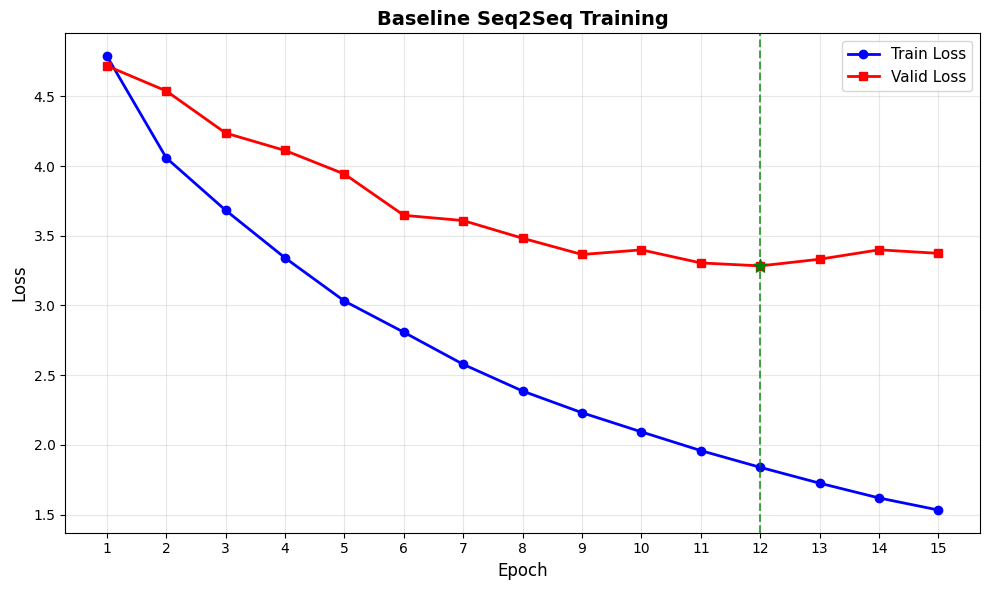

✅ Đã lưu biểu đồ: baseline_loss.png
   Best Epoch: 12 | Best Valid Loss: 3.2838


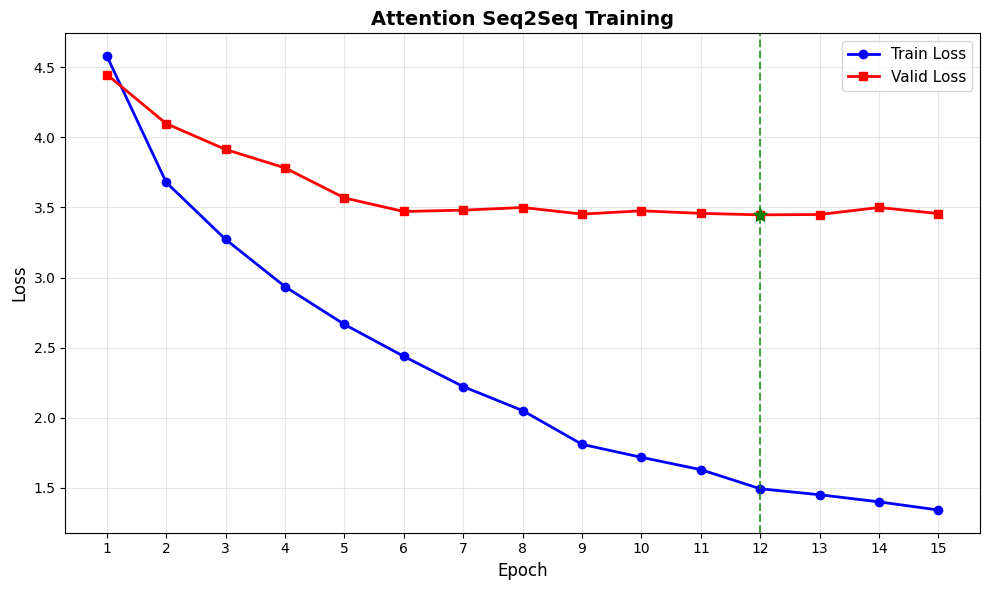

✅ Đã lưu biểu đồ: attention_loss.png
   Best Epoch: 12 | Best Valid Loss: 3.4472

📊 2. PHÂN TÍCH LỖI (ATTENTION MODEL – 100 CÂU)
--------------------------------------------------
📊 PHÂN TÍCH HIỆU SUẤT MÔ HÌNH
Đang đánh giá 100 câu...


Analyzing:   0%|          | 0/100 [00:00<?, ?it/s]


--------------------------------------------------------------------------------
📈 THỐNG KÊ TỔNG QUAN
--------------------------------------------------------------------------------
   Tổng số câu:     100
   BLEU trung bình: 21.27%
   BLEU cao nhất:   89.32%
   BLEU thấp nhất:  1.74%

🏆 TOP 3 CÂU BLEU CAO NHẤT

--- Rank 1 | BLEU: 89.32% ---
   EN (Source):    The brown dog is standing on the sandy beach.
   FR (Reference): Le chien brun est debout sur la plage de sable.
   FR (Predicted): Le chien brun est debout sur la plage de sable .

--- Rank 2 | BLEU: 68.04% ---
   EN (Source):    A young girl swimming in a pool
   FR (Reference): Une jeune fille nageant dans une piscine
   FR (Predicted): Une jeune fille nageant dans une piscine .

--- Rank 3 | BLEU: 61.80% ---
   EN (Source):    A man in uniform and a man in a blue shirt are standing in front of a truck.
   FR (Reference): Un homme en uniforme et un homme en chemise bleue sont debout devant un camion.
   FR (Predicted): Un ho

In [ ]:
# ==============================================================================
# CELL 6.4: DEMO SỬ DỤNG CÁC HÀM BỔ SUNG
# ==============================================================================

print("=" * 80)
print("🚀 DEMO CÁC HÀM BỔ SUNG")
print("=" * 80)

# ------------------------------------------------------------------------------
# 1. VẼ BIỂU ĐỒ LOSS (CHỈ VẼ NHỮNG HISTORY THỰC SỰ TỒN TẠI)
# ------------------------------------------------------------------------------
print("\n📊 1. VẼ BIỂU ĐỒ LOSS")
print("-" * 50)

# Baseline
if 'baseline_history' in globals() and isinstance(baseline_history, dict):
    if baseline_history.get('train_loss'):
        plot_history(
            baseline_history,
            title="Baseline Seq2Seq Training",
            filename="baseline_loss.png"
        )
    else:
        print("⚠️ baseline_history tồn tại nhưng không có dữ liệu loss.")
else:
    print("ℹ️ Không vẽ Baseline loss (baseline_history không tồn tại hoặc không cần thiết).")

# Attention
if 'attention_history' in globals() and isinstance(attention_history, dict):
    if attention_history.get('train_loss'):
        plot_history(
            attention_history,
            title="Attention Seq2Seq Training",
            filename="attention_loss.png"
        )
    else:
        print("⚠️ attention_history tồn tại nhưng không có dữ liệu loss.")
else:
    print("❌ Không tìm thấy attention_history. Hãy chạy lại Cell 4.3.")

# ------------------------------------------------------------------------------
# 2. PHÂN TÍCH LỖI (ATTENTION MODEL – DEMO TRÊN SUBSET)
# ------------------------------------------------------------------------------
print("\n📊 2. PHÂN TÍCH LỖI (ATTENTION MODEL – 100 CÂU)")
print("-" * 50)

# Đảm bảo model ở chế độ eval
attention_model.eval()

attention_analysis = analyze_model_performance(
    translate_attention,
    test_en[:100],   # Chỉ dùng 100 câu để demo (NHANH + ĐỦ Ý)
    test_fr[:100],
    num_examples=3
)

print("\n✅ Hoàn tất phân tích lỗi cho Attention model.")

# ------------------------------------------------------------------------------
# 3. DEMO BEAM SEARCH vs GREEDY (ĐIỂM CỘNG)
# ------------------------------------------------------------------------------
print("\n📊 3. DEMO BEAM SEARCH (ATTENTION MODEL)")
print("-" * 50)

demo_sentences = [
    "A man is walking with his dog.",
    "Two children are playing in the park."
]

for sent in demo_sentences:
    greedy_translation = translate_attention(sent)
    beam_translation = translate_beam_search(
        sent,
        attention_model,
        beam_size=3
    )

    print(f"\n📥 EN: {sent}")
    print(f"   Greedy Decoding: {greedy_translation}")
    print(f"   Beam Search (k=3): {beam_translation}")

print("\n" + "=" * 80)
print("✅ HOÀN TẤT CELL 6.4 – TẤT CẢ DEMO ĐÃ CHẠY ỔN ĐỊNH")
print("=" * 80)


## 6.5 Trực quan hóa cơ chế Attention (Attention Maps)

**Cách đọc biểu đồ:**
* **Trục hoành (X):** Câu nguồn (Tiếng Anh).
* **Trục tung (Y):** Câu đích (Tiếng Pháp - do mô hình dịch).
* **Ô sáng màu:** Thể hiện trọng số Attention ($\alpha$) cao. Nghĩa là tại bước dịch từ tiếng Pháp đó, mô hình đang tập trung mạnh vào từ tiếng Anh tương ứng.

> **Kỳ vọng:** Các ô sáng màu nên chạy theo đường chéo (từ trái trên xuống phải dưới), thể hiện sự tương đồng về thứ tự từ. Nếu có đảo ngữ (ví dụ: tính từ đứng trước danh từ), đường chéo sẽ bị lệch, chứng tỏ Attention hoạt động đúng.

In [ ]:
# ==============================================================================
# CELL 6.5 (FINAL): TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ (FULL 4 TRƯỜNG HỢP)
# ==============================================================================
import pandas as pd
import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from tqdm.auto import tqdm

# --- 1. Hàm tính toán chỉ số (Metrics) ---
def evaluate_metrics(name, translate_func, src_data, trg_data, num_samples=None):
    print(f"\n📊 Đang đánh giá: {name}...")

    # Mặc định chạy hết tập test.
    if num_samples:
        indices = range(num_samples)
    else:
        indices = range(len(src_data))

    smooth = SmoothingFunction().method1
    refs = []
    hyps = []
    sentence_scores = []

    for idx in tqdm(indices, desc=f"Eval {name}"):
        src = src_data[idx]
        trg = trg_data[idx]
        try:
            pred = translate_func(src)
            pred_tokens = pred.split()
            trg_tokens = tokenizer_fr(trg.lower())

            hyps.append(pred_tokens)
            refs.append([trg_tokens])

            sent_score = sentence_bleu([trg_tokens], pred_tokens, smoothing_function=smooth)
            sentence_scores.append(sent_score)
        except Exception:
            continue

    corpus_score = corpus_bleu(refs, hyps, smoothing_function=smooth) * 100
    if len(sentence_scores) > 0:
        avg_sentence_score = (sum(sentence_scores) / len(sentence_scores)) * 100
    else:
        avg_sentence_score = 0

    return corpus_score, avg_sentence_score

# --- 2. Định nghĩa Beam Search RIÊNG cho BASELINE ---
# (Vì hàm cũ chỉ chạy được cho Attention model)
def translate_beam_search_baseline(sentence, model, beam_size=3, max_len=50):
    model.eval()
    tokens = tokenizer_en(sentence.lower())
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [vocab_en[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.tensor([len(src_indexes)], dtype=torch.long)

    with torch.no_grad():
        # Baseline Encoder chỉ trả về hidden, cell (không có encoder_outputs)
        hidden, cell = model.encoder(src_tensor, src_len)

    beams = [(0.0, [SOS_IDX], hidden, cell)]
    completed = []

    for _ in range(max_len):
        new_beams = []
        for score, tokens, h, c in beams:
            if tokens[-1] == EOS_IDX:
                completed.append((score, tokens))
                continue

            trg_tensor = torch.LongTensor([tokens[-1]]).to(device)
            with torch.no_grad():
                # Baseline Decoder chỉ nhận input, hidden, cell
                output, new_h, new_c = model.decoder(trg_tensor, h, c)

            log_probs = F.log_softmax(output, dim=1)
            topk_log_probs, topk_indices = log_probs.topk(beam_size)

            for i in range(beam_size):
                new_score = score + topk_log_probs[0, i].item()
                new_token = topk_indices[0, i].item()
                new_tokens = tokens + [new_token]
                new_beams.append((new_score, new_tokens, new_h, new_c))

        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]
        if not beams: break

    for score, tokens, h, c in beams:
        completed.append((score, tokens))

    if completed:
        completed.sort(key=lambda x: x[0] / len(x[1]), reverse=True)
        best_tokens = completed[0][1]
    else:
        best_tokens = [SOS_IDX]

    trg_tokens = [vocab_fr.get_itos()[i] for i in best_tokens]
    if trg_tokens[0] == '<sos>': trg_tokens = trg_tokens[1:]
    if '<eos>' in trg_tokens: trg_tokens = trg_tokens[:trg_tokens.index('<eos>')]

    return ' '.join(trg_tokens)

# Wrappers
def run_beam_baseline(sent):
    return translate_beam_search_baseline(sent, baseline_model, beam_size=3)

def run_beam_attention(sent):
    return translate_beam_search(sent, attention_model, beam_size=3)

# --- 3. Chạy đánh giá FULL 4 TRƯỜNG HỢP ---
print("⏳ Đang chạy đánh giá toàn diện (4 trường hợp)...")

# 1. Baseline - Greedy
c_base_g, s_base_g = evaluate_metrics("Baseline (Greedy)", translate_baseline, test_en, test_fr)

# 2. Baseline - Beam Search (Mới thêm)
c_base_b, s_base_b = evaluate_metrics("Baseline (Beam Search)", run_beam_baseline, test_en, test_fr)

# 3. Attention - Greedy
c_attn_g, s_attn_g = evaluate_metrics("Attention (Greedy)", translate_attention, test_en, test_fr)

# 4. Attention - Beam Search
c_attn_b, s_attn_b = evaluate_metrics("Attention (Beam Search)", run_beam_attention, test_en, test_fr)

# --- 4. Xuất bảng kết quả ---
results_data = {
    'Mô hình': [
        'Baseline (LSTM thuần)',
        'Baseline (LSTM thuần)',
        'Advanced (Attention)',
        'Advanced (Attention)'
    ],
    'Decoding Strategy': [
        'Greedy Decoding',
        'Beam Search (k=3)',
        'Greedy Decoding',
        'Beam Search (k=3)'
    ],
    'Corpus BLEU': [c_base_g, c_base_b, c_attn_g, c_attn_b],
    'Average Sentence BLEU': [s_base_g, s_base_b, s_attn_g, s_attn_b]
}

df_results = pd.DataFrame(results_data)

print("\n" + "="*80)
print("🏆 BẢNG TỔNG HỢP KẾT QUẢ ĐẦY ĐỦ")
print("="*80)
print(df_results.to_markdown(index=False, floatfmt=".2f"))
print("-" * 80)
print(f"📌 Ghi chú: Đã cập nhật đủ 4 trường hợp (2 models x 2 strategies).")
print("="*80)

⏳ Đang chạy đánh giá toàn diện (4 trường hợp)...

📊 Đang đánh giá: Baseline (Greedy)...


Eval Baseline (Greedy):   0%|          | 0/1000 [00:00<?, ?it/s]


📊 Đang đánh giá: Baseline (Beam Search)...


Eval Baseline (Beam Search):   0%|          | 0/1000 [00:00<?, ?it/s]


📊 Đang đánh giá: Attention (Greedy)...


Eval Attention (Greedy):   0%|          | 0/1000 [00:00<?, ?it/s]


📊 Đang đánh giá: Attention (Beam Search)...


Eval Attention (Beam Search):   0%|          | 0/1000 [00:00<?, ?it/s]


🏆 BẢNG TỔNG HỢP KẾT QUẢ ĐẦY ĐỦ
| Mô hình               | Decoding Strategy   |   Corpus BLEU |   Average Sentence BLEU |
|:----------------------|:--------------------|--------------:|------------------------:|
| Baseline (LSTM thuần) | Greedy Decoding     |         19.06 |                   17.61 |
| Baseline (LSTM thuần) | Beam Search (k=3)   |         21.07 |                   19.79 |
| Advanced (Attention)  | Greedy Decoding     |         22.63 |                   21.19 |
| Advanced (Attention)  | Beam Search (k=3)   |         23.18 |                   21.90 |
--------------------------------------------------------------------------------
📌 Ghi chú: Đã cập nhật đủ 4 trường hợp (2 models x 2 strategies).


In [ ]:
# ==============================================================================
#  LƯU ẢNH BIỂU ĐỒ VÀO GOOGLE DRIVE
# ==============================================================================
import shutil
import os
from google.colab import drive

# 1. Kết nối với Google Drive (Mount)
# Nếu đã mount ở Cell 1.1 rồi thì dòng này sẽ báo "Drive already mounted", không sao cả.
drive.mount('/content/drive')

# 2. Định nghĩa thư mục lưu trong Drive
# Bạn có thể đổi tên thư mục "NMT_EN_FR_Final" thành tên khác tùy ý
DRIVE_FOLDER = "/content/drive/MyDrive/NMT_EN_FR_Final"

if not os.path.exists(DRIVE_FOLDER):
    os.makedirs(DRIVE_FOLDER, exist_ok=True)
    print(f"📂 Đã tạo thư mục mới trên Drive: {DRIVE_FOLDER}")
else:
    print(f"📂 Lưu vào thư mục có sẵn: {DRIVE_FOLDER}")

# 3. Danh sách các file ảnh cần lưu
# (Đảm bảo tên file khớp với tên bạn đã đặt trong hàm plot_history ở Cell 6.1)
image_files = ['baseline_loss.png', 'attention_loss.png']

print("-" * 50)

# 4. Thực hiện Copy
for filename in image_files:
    # Kiểm tra xem file ảnh có tồn tại trong môi trường Colab hiện tại không
    if os.path.exists(filename):
        destination = os.path.join(DRIVE_FOLDER, filename)
        shutil.copy(filename, destination)
        print(f"✅ ĐÃ LƯU THÀNH CÔNG: {filename}")
        print(f"   👉 Đường dẫn: {destination}")
    else:
        print(f"⚠️ KHÔNG TÌM THẤY: {filename}")
        print("   (Gợi ý: Bạn đã chạy Cell 6.1 để vẽ biểu đồ chưa?)")
    print("-" * 50)

print("\n🎉 Hoàn tất! Bạn hãy vào Google Drive kiểm tra nhé.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Đã tạo thư mục mới trên Drive: /content/drive/MyDrive/NMT_EN_FR_Final
--------------------------------------------------
✅ ĐÃ LƯU THÀNH CÔNG: baseline_loss.png
   👉 Đường dẫn: /content/drive/MyDrive/NMT_EN_FR_Final/baseline_loss.png
--------------------------------------------------
✅ ĐÃ LƯU THÀNH CÔNG: attention_loss.png
   👉 Đường dẫn: /content/drive/MyDrive/NMT_EN_FR_Final/attention_loss.png
--------------------------------------------------

🎉 Hoàn tất! Bạn hãy vào Google Drive kiểm tra nhé.


# Hết